In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from pandas import read_csv

# Preprocessing
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE, RFECV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, FunctionTransformer
)

# Model Selection
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_validate,
    RandomizedSearchCV, RepeatedStratifiedKFold, KFold
)

# Metrics
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, make_scorer
)

# Classifiers and base models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    ExtraTreesClassifier, VotingClassifier, StackingClassifier, HistGradientBoostingClassifier,
    BaggingClassifier
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Pipelines and column transforms
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Resampling methods (imbalanced-learn)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, RandomOverSampler
from imblearn.under_sampling import NearMiss, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN

# Suppress warnings (optional)
import warnings
warnings.filterwarnings("ignore")


# Loading and exploring data

In [2]:
columns = ['Age', 'Female', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/R']

X_train = pd.read_csv("train_features_ILDS.csv", header=None, names=columns)
y_train = pd.read_csv("train_labels_ILDS.csv", header=None, names=['Label']).values.ravel()
X_train["Female"] = X_train["Female"].astype(int)

X_train = X_train[[col for col in X_train.columns if col != 'Female'] + ['Female']]

X_test = pd.read_csv("test_data_ILDS.csv", header=None, names=columns)
X_test["Female"] = X_test["Female"].astype(int)

X_test = X_test[[col for col in X_test.columns if col != 'Female'] + ['Female']]

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (463, 10)
Test data shape: (116, 10)
Training labels shape: (463,)


NameError: name 'y_test' is not defined

In [ ]:
print("=== DATAFRAME STRUCTURE ===")
print(X_train.info())
print("\n=== UNIQUE VALUES PER COLUMN ===")
print(X_train.nunique())
print("\n=== MISSING VALUES ===")
missing = X_train.isnull().sum()
print(missing[missing > 0])

print("\n=== ROWS WITH MISSING VALUES ===")
print(X_train[X_train.isnull().any(axis=1)].head())


=== DATAFRAME STRUCTURE ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      463 non-null    int64  
 1   TB       463 non-null    float64
 2   DB       463 non-null    float64
 3   Alkphos  463 non-null    int64  
 4   Sgpt     463 non-null    int64  
 5   Sgot     463 non-null    int64  
 6   TP       463 non-null    float64
 7   ALB      463 non-null    float64
 8   A/R      463 non-null    float64
 9   Female   463 non-null    int32  
dtypes: float64(5), int32(1), int64(4)
memory usage: 34.5 KB
None

=== UNIQUE VALUES PER COLUMN ===
Age         71
TB          98
DB          70
Alkphos    222
Sgpt       136
Sgot       156
TP          54
ALB         40
A/R         64
Female       2
dtype: int64

=== MISSING VALUES ===
Series([], dtype: int64)

=== ROWS WITH MISSING VALUES ===
Empty DataFrame
Columns: [Age, TB, DB, Alkphos, Sgpt, Sgot, TP, A

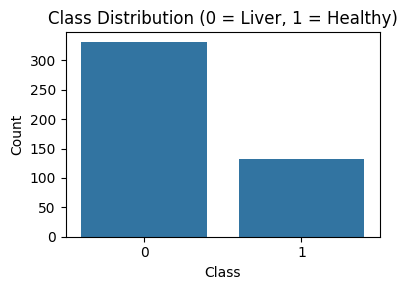

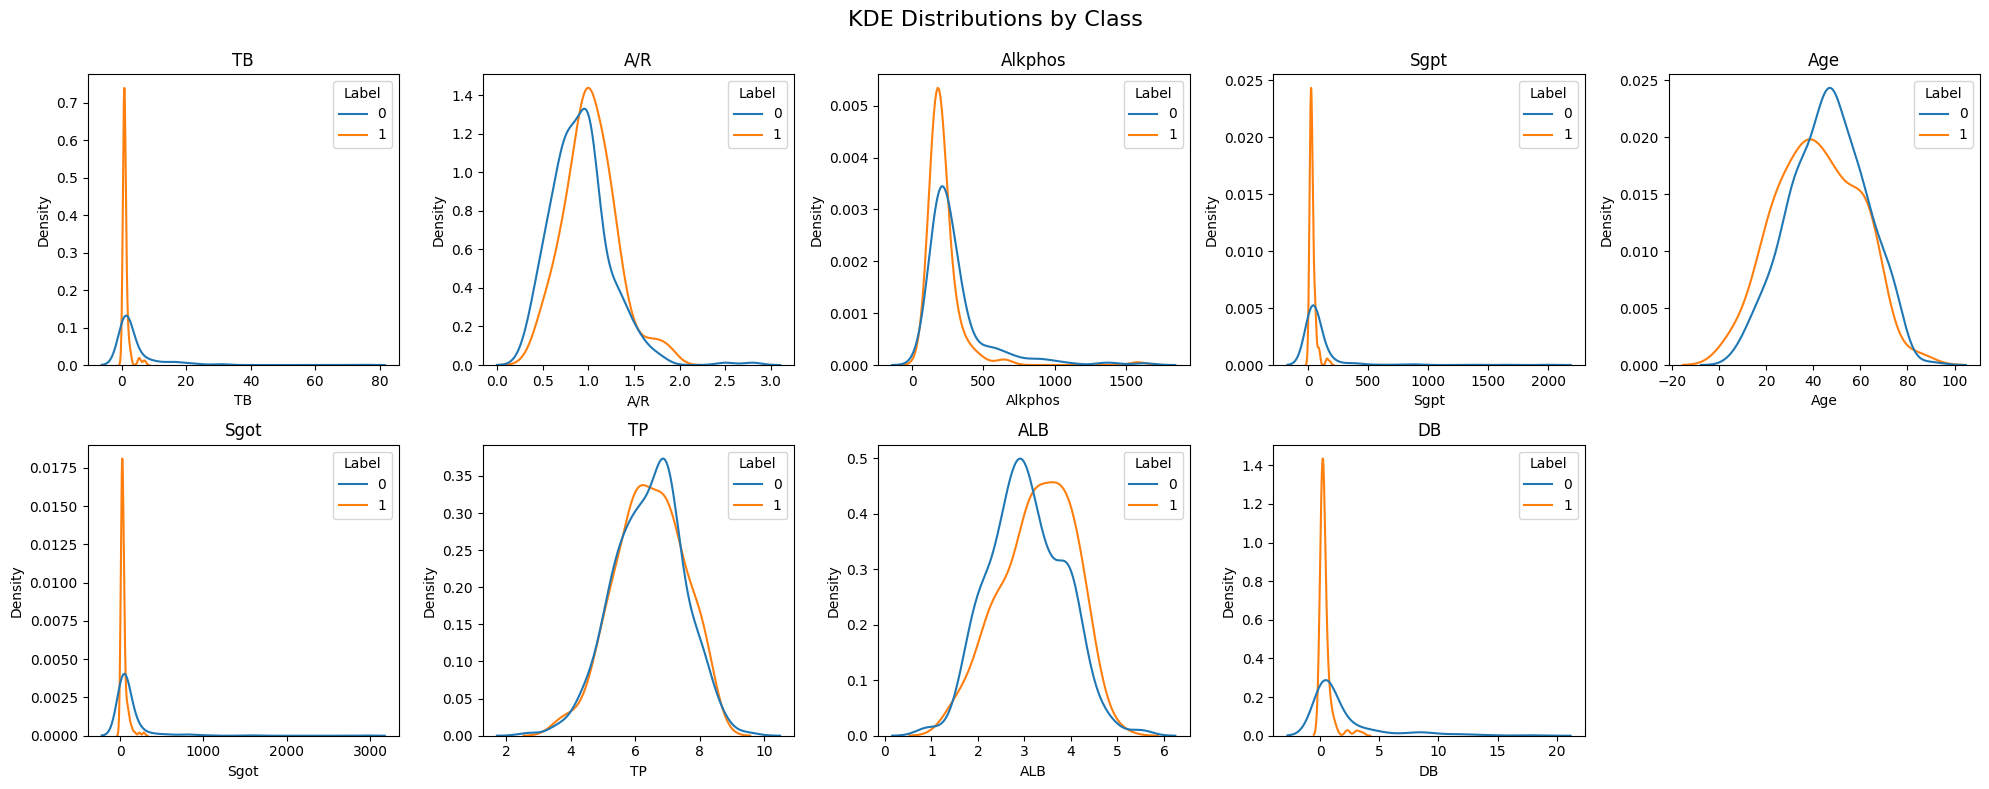

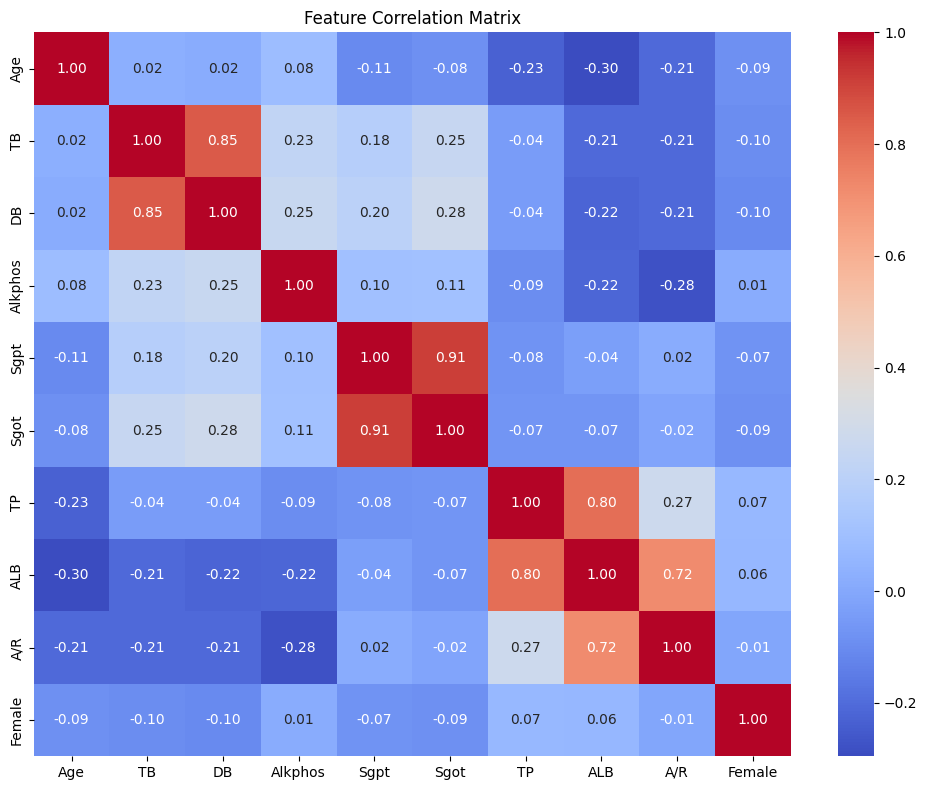

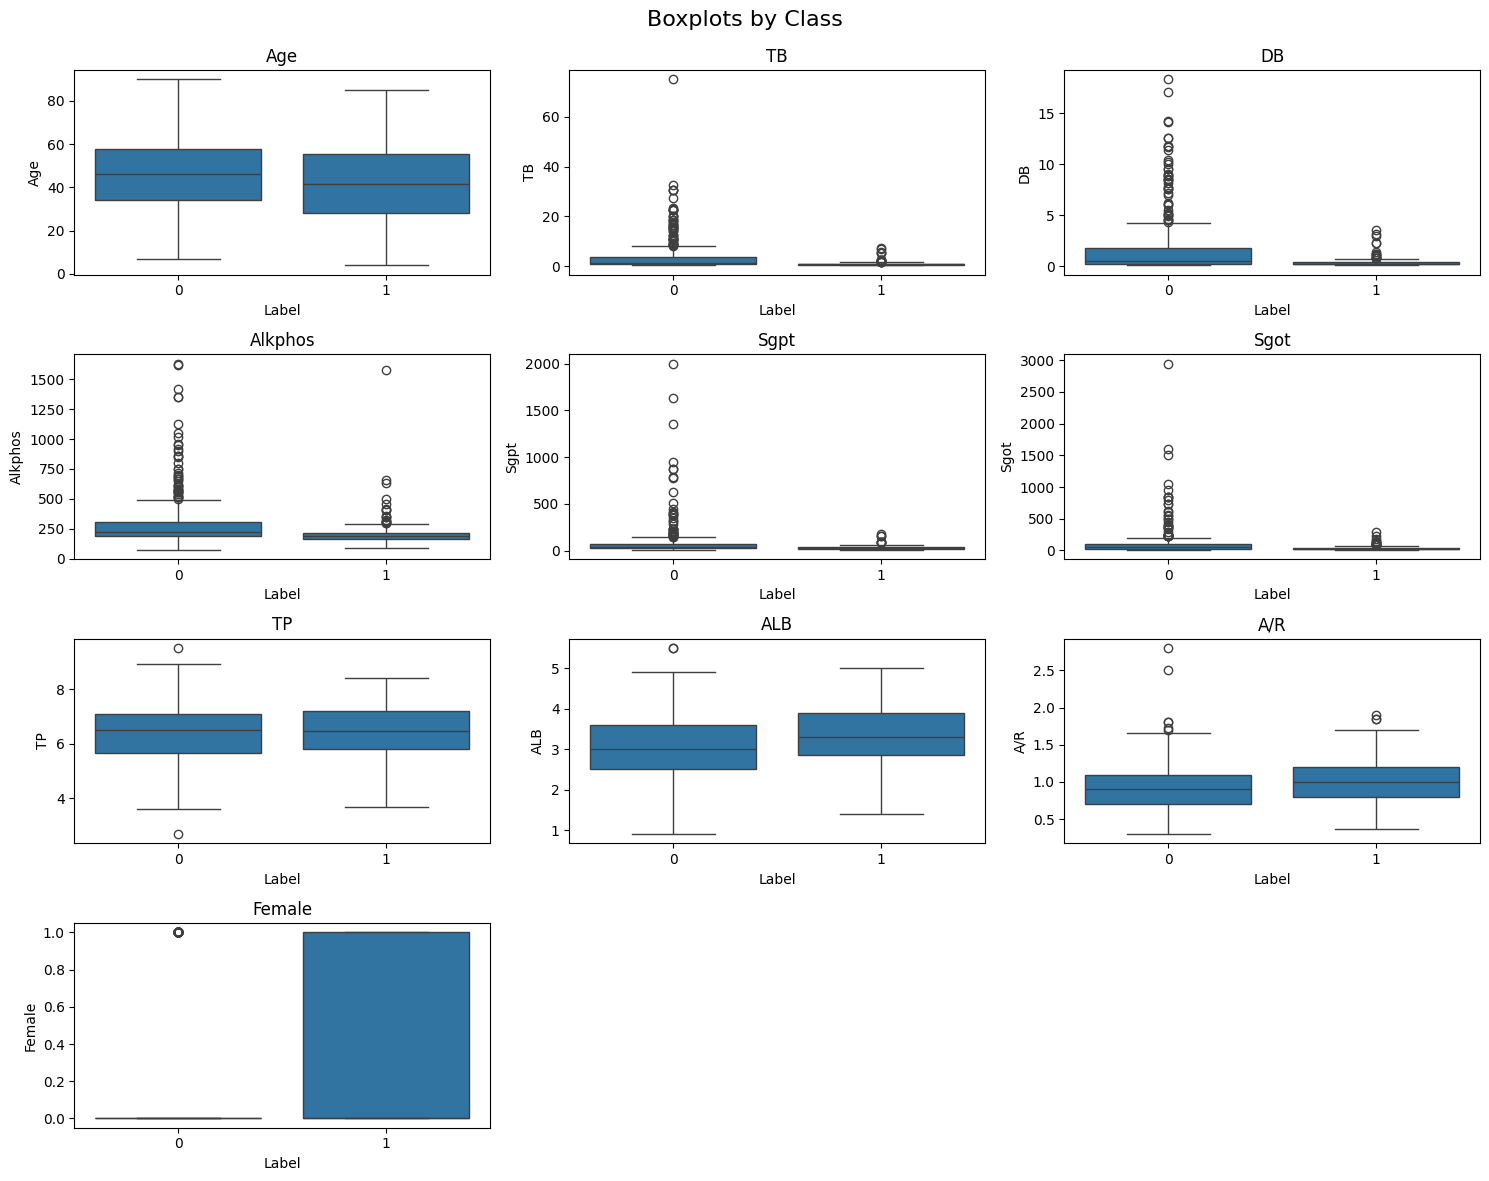

In [ ]:
# Combine into a single DataFrame for EDA
df = X_train.copy()
df['Label'] = y_train

# 1. Class distribution
fig, ax = plt.subplots(figsize=(4, 3))
sns.countplot(x='Label', data=df, ax=ax)
ax.set_title('Class Distribution (0 = Liver, 1 = Healthy)')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# 2. KDE plots for selected features
kde_features = ['TB', 'A/R', 'Alkphos', 'Sgpt', 'Age', 'Sgot', 'TP', 'ALB', 'DB']
n_features = len(kde_features)
n_cols = int(np.ceil(n_features / 2))
n_rows = 2

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(kde_features):
    sns.kdeplot(data=df, x=feature, hue='Label', common_norm=False, ax=axes[i])
    axes[i].set_title(f'{feature}')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle("KDE Distributions by Class", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

# 3. Correlation heatmap
plt.figure(figsize=(10, 8))
corr = df.drop(columns='Label').corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# 4. Boxplots for all features EXCEPT 'Female'
box_features = [col for col in df.drop(columns='Label').columns if col != 'Female']
n_cols = 3
n_rows = int(np.ceil(len(box_features) / n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

for i, feature in enumerate(box_features):
    sns.boxplot(x='Label', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature}')
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Boxplots by Class (excluding Female)", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# 5. QQ-plots for all numerical features (excluding 'Female' and 'Label')
import scipy.stats as stats

qq_features = [col for col in df.columns if col not in ['Label', 'Female']]
n_cols = 3
n_rows = int(np.ceil(len(qq_features) / n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(qq_features):
    stats.probplot(df[feature].dropna(), dist="norm", plot=axes[i])
    axes[i].set_title(f'QQ-plot: {feature}')
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("QQ-plots for Numerical Features", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


The exploratory data analysis of this liver disease dataset reveals several important insights regarding feature distributions, relationships, and their potential relevance for classification.

Class Distribution
The class distribution is clearly imbalanced, with a higher number of individuals labeled as 0 (Liver disease) compared to those labeled as 1 (Healthy). This imbalance suggests that caution must be taken during model training to avoid bias toward the majority class. Techniques such as oversampling (e.g., SMOTE), undersampling, or cost-sensitive learning could be considered to address this issue.

Boxplots by Class
The boxplots offer a detailed visualization of how each feature varies across the two classes. Several variables show substantial differences between the classes:

Total Bilirubin (TB) and Direct Bilirubin (DB) exhibit higher medians and more outliers in class 0, consistent with elevated bilirubin levels in patients with liver dysfunction.

Alkaline Phosphotase (Alkphos), SGPT, and SGOT show a large number of extreme values in the diseased group, indicating that liver enzyme levels are significantly more variable and generally higher in these patients.

Albumin (ALB) and A/G Ratio (A/R) are slightly higher in the healthy group, reflecting potentially better protein synthesis function in individuals without liver issues.

Total Proteins (TP) shows less variation across groups but still some observable differences.

The Age distribution is fairly similar in both classes, suggesting it may not be a strong predictor on its own.

The Female feature (likely a binary gender indicator) appears skewed across classes, which might suggest sampling bias or gender-related clinical factors.

Overall, SGPT, SGOT, Alkphos, TB, and DB appear to be the most discriminative features between classes.

Correlation Matrix
The correlation heatmap shows several strong pairwise relationships:

TB and DB are highly correlated (0.85), which is expected given that DB is a component of TB.

SGPT and SGOT have an exceptionally strong correlation (0.91), reflecting their physiological linkage as liver enzymes.

TP and ALB also correlate strongly (0.80), suggesting some redundancy between these protein-related measures.

Most other features show low to moderate correlations, and Age is weakly correlated with all other features. The presence of strong correlations (e.g., between SGPT and SGOT) could lead to multicollinearity, which may be problematic for certain models like logistic regression. Dimensionality reduction techniques or feature selection methods could be used to mitigate this.

KDE Distributions
Kernel Density Estimation (KDE) plots provide a smoothed view of the feature distributions by class:

SGPT, SGOT, and Alkphos have long right tails for class 0, reflecting extreme liver enzyme values in diseased individuals. Class 1 distributions are narrower and more concentrated at lower values.

TB and DB distributions are skewed right in class 0, again consistent with clinical expectations.

ALB and A/G Ratio show moderate separation, with class 1 having slightly higher values, indicating more stable liver function.

TP differences are more subtle but still visible.

Age KDEs overlap considerably, reaffirming its limited discriminative power.

These plots reinforce the findings from the boxplots and suggest that non-parametric models or transformations may better handle the skewed distributions observed in some features.

# Function and model declarations

## Preprocessing related functions

 We will now see if there's some outliers, we'll test it in three different ways (and tolerances).

In [78]:
def remove_outliers_iqr(X, y, factor=1.5):
    X_out = X.copy()
    y_out = y.copy()
    outlier_indices = set()

    for col in X.columns:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        mask = (X[col] < lower_bound) | (X[col] > upper_bound)
        outlier_indices.update(X[mask].index)

    outlier_indices = list(outlier_indices)
    X_clean = X.drop(index=outlier_indices)
    y_clean = y.drop(index=outlier_indices)
    y_outliers = y.loc[outlier_indices]

    return X_clean, y_clean, y_outliers


def remove_outliers_zscore(X, y, threshold=3):
    zscores = X.apply(zscore)
    mask = (np.abs(zscores) < threshold).all(axis=1)
    X_clean = X[mask]
    y_clean = y[mask]
    y_outliers = y[~mask]
    return X_clean, y_clean, y_outliers


def remove_outliers_percentile(X, y, lower=0.01, upper=0.99):
    mask = np.ones(len(X), dtype=bool)
    for col in X.columns:
        low = X[col].quantile(lower)
        high = X[col].quantile(upper)
        mask &= (X[col] >= low) & (X[col] <= high)

    X_clean = X[mask]
    y_clean = y[mask]
    y_outliers = y[~mask]
    return X_clean, y_clean, y_outliers


In [79]:
if isinstance(y_train, np.ndarray):
    y_train_series = pd.Series(y_train, index=X_train.index)
else:
    y_train_series = y_train

X_iqr, y_iqr, y_iqr_outliers = remove_outliers_iqr(X_train, y_train_series)
X_z, y_z, y_z_outliers = remove_outliers_zscore(X_train, y_train_series)
X_pct, y_pct, y_pct_outliers = remove_outliers_percentile(X_train, y_train_series)

print("Outliers removed by IQR method:")
print(y_iqr_outliers.value_counts())

print("Outliers removed by Z-score method:")
print(y_z_outliers.value_counts())

print("Outliers removed by Percentile method:")
print(y_pct_outliers.value_counts())
# ...existing code...

Outliers removed by IQR method:
0    182
1     47
Name: count, dtype: int64
Outliers removed by Z-score method:
0    40
1     2
Name: count, dtype: int64
Outliers removed by Percentile method:
0    34
1    20
Name: count, dtype: int64


 We have tried several models with different outlier treatment methods and there is not an improvement. W have decided to just use the scaler robust, which mitigates the outliers. It improves much more.

# Pipeline Creation

## Different Data pipeline

We're going to apply different transfomrations to data. Data can be normalized, Scaled, k-best features can be selected, and correlation can be treated.

For each model, we perform an exhaustive search for every combination of data preprocess.

This is done through a variable pipeline, defined afterwards

In [80]:
yeojohnson_transform = ColumnTransformer(
    transformers=[
        ('yeojohnson', PowerTransformer(method='yeo-johnson'), slice(0, None))
    ],
    remainder='passthrough'
)
identity = FunctionTransformer(lambda X: X)

norm = {yeojohnson_transform: "Yeo-Johnson",
        identity: "Identity"
        }

In [81]:
scalerMinMax = ColumnTransformer(
    transformers=[
        ('MinMax', MinMaxScaler(), slice(0, None))
    ],
    remainder='passthrough'
)

scalerRobust = ColumnTransformer(
    transformers=[
        ('Robust', RobustScaler(), slice(0, None))
    ],
    remainder='passthrough'
)

identity_scaler = FunctionTransformer(lambda X: X)

scal = {
    scalerMinMax: "MinMax",
    scalerRobust: "Robust",
    identity_scaler: "Identity",
}


alwayscal = {
    scalerMinMax: "MinMax",
    scalerRobust: "Robust",
}


In [82]:
select_k5 = ColumnTransformer([
    ('kbest', SelectKBest(score_func=f_classif, k=5), slice(0, -1)),
    ('cat', 'passthrough', [-1])
])
select_k3 = ColumnTransformer([
    ('kbest', SelectKBest(score_func=f_classif, k=3), slice(0, -1)),
    ('cat', 'passthrough', [-1])
])

rf_selector_5 = ColumnTransformer([
    ('rf', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), 
                           max_features=5, threshold=-np.inf), slice(0, -1)),
    ('cat', 'passthrough', [-1])
])
rf_selector_3 = ColumnTransformer([
    ('rf', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), 
                           max_features=3, threshold=-np.inf), slice(0, -1)),
    ('cat', 'passthrough', [-1])
])

xgb_selector_5 = ColumnTransformer([
    ('xgb', SelectFromModel(XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'), 
                            max_features=5, threshold=-np.inf), slice(0, -1)),
    ('cat', 'passthrough', [-1])
])
xgb_selector_3 = ColumnTransformer([
    ('xgb', SelectFromModel(XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'), 
                            max_features=3, threshold=-np.inf), slice(0, -1)),
    ('cat', 'passthrough', [-1])
])

rfe_rf_5 = ColumnTransformer([
    ('rfe', RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=5), slice(0, -1)),
    ('cat', 'passthrough', [-1])
])
rfe_rf_3 = ColumnTransformer([
    ('rfe', RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=3), slice(0, -1)),
    ('cat', 'passthrough', [-1])
])

rfecv_rf = ColumnTransformer([
    ('rfecv', RFECV(RandomForestClassifier(n_estimators=100, random_state=42), cv=3, scoring='accuracy'), slice(0, -1)),
    ('cat', 'passthrough', [-1])
])

identity_selector = FunctionTransformer(lambda X: X)

general_selector = {
    identity : "Identity",
    select_k5: "SelectKBest_5",
    select_k3: "SelectKBest_3"
}

xgb_selector = {
    identity : "Identity",
    xgb_selector_5 : "XGB_Select_5",
    xgb_selector_3 : "XGB_Select_3"
}

rf_selector = {
    identity:"Identity",
    rfecv_rf:"RFECV_RF",
    select_k5: "SelectKBest_5",
    rfe_rf_3: "RFE_RF_3"
}


In [83]:
identity_corr = FunctionTransformer(lambda X: X)

def divide_and_remove(X):
    X_new = X.copy()
    if isinstance(X_new, pd.DataFrame):
        X_new['DB_TB'] = X_new['DB'] / X_new['TB'].replace(0, 1e-6)
        X_new['Sgot_Sgpt'] = X_new['Sgot'] / X_new['Sgpt'].replace(0, 1e-6)
        X_new = X_new.drop(columns=['DB', 'TB', 'Sgot', 'Sgpt'])
    elif isinstance(X_new, np.ndarray):
        db_tb = X_new[:,3] / np.where(X_new[:,2]==0, 1e-6, X_new[:,2])
        sgot_sgpt = X_new[:,6] / np.where(X_new[:,5]==0, 1e-6, X_new[:,5])
        mask = np.ones(X_new.shape[1], dtype=bool)
        mask[[2,3,5,6]] = False
        X_new = np.concatenate([X_new[:,mask], db_tb[:,None], sgot_sgpt[:,None]], axis=1)
    return X_new
division_corr = FunctionTransformer(divide_and_remove)

def regress_sgot_on_sgpt(X):
    X_new = X.copy()
    if isinstance(X_new, pd.DataFrame):
        model = LinearRegression()
        model.fit(X_new[['Sgpt']], X_new['Sgot'])
        residuals = X_new['Sgot'] - model.predict(X_new[['Sgpt']])
        X_new = X_new.drop(columns=['Sgot'])
        X_new['Sgot_resid'] = residuals
    elif isinstance(X_new, np.ndarray):
        sgpt = X_new[:,5].reshape(-1,1)
        sgot = X_new[:,6]
        model = LinearRegression()
        model.fit(sgpt, sgot)
        residuals = sgot - model.predict(sgpt)
        mask = np.ones(X_new.shape[1], dtype=bool)
        mask[6] = False
        X_new = np.concatenate([X_new[:,mask], residuals[:,None]], axis=1)
    return X_new
regression_corr = FunctionTransformer(regress_sgot_on_sgpt)

def regress_db_on_tb(X):
    X_new = X.copy()
    if isinstance(X_new, pd.DataFrame):
        model = LinearRegression()
        model.fit(X_new[['TB']], X_new['DB'])
        residuals = X_new['DB'] - model.predict(X_new[['TB']])
        X_new = X_new.drop(columns=['DB'])
        X_new['DB_resid'] = residuals
    elif isinstance(X_new, np.ndarray):
        tb = X_new[:,2].reshape(-1,1)
        db = X_new[:,3]
        model = LinearRegression()
        model.fit(tb, db)
        residuals = db - model.predict(tb)
        mask = np.ones(X_new.shape[1], dtype=bool)
        mask[3] = False 
        X_new = np.concatenate([X_new[:,mask], residuals[:,None]], axis=1)
    return X_new

regression_db_tb_corr = FunctionTransformer(regress_db_on_tb)

def three_divisions(X):
    X_new = X.copy()
    X_new['DB_TB'] = X_new['DB'] / X_new['TB'].replace(0, 1e-6)
    X_new['Sgot_Sgpt'] = X_new['Sgot'] / X_new['Sgpt'].replace(0, 1e-6)
    X_new['ALB_TP'] = X_new['ALB'] / X_new['TP'].replace(0, 1e-6)
    X_new = X_new.drop(columns=['DB', 'TB', 'Sgot', 'Sgpt', 'ALB', 'TP'])
    return X_new

three_div_corr = FunctionTransformer(three_divisions)

def regress_db_on_tb(X):
    X_new = X.copy()
    if isinstance(X_new, pd.DataFrame):
        model = LinearRegression()
        model.fit(X_new[['TB']], X_new['DB'])
        residuals = X_new['DB'] - model.predict(X_new[['TB']])
        X_new = X_new.drop(columns=['DB'])
        X_new['DB_resid'] = residuals
    elif isinstance(X_new, np.ndarray):
        tb = X_new[:,2].reshape(-1,1)
        db = X_new[:,3]
        model = LinearRegression()
        model.fit(tb, db)
        residuals = db - model.predict(tb)
        mask = np.ones(X_new.shape[1], dtype=bool)
        mask[3] = False
        X_new = np.concatenate([X_new[:,mask], residuals[:,None]], axis=1)
    return X_new

regression_db_tb_corr = FunctionTransformer(regress_db_on_tb)

def regress_both(X):
    X_new = X.copy()
    if isinstance(X_new, pd.DataFrame):
        model_sgot = LinearRegression()
        model_sgot.fit(X_new[['Sgpt']], X_new['Sgot'])
        sgot_resid = X_new['Sgot'] - model_sgot.predict(X_new[['Sgpt']])
        X_new = X_new.drop(columns=['Sgot'])
        X_new['Sgot_resid'] = sgot_resid

        model_db = LinearRegression()
        model_db.fit(X_new[['TB']], X_new['DB'])
        db_resid = X_new['DB'] - model_db.predict(X_new[['TB']])
        X_new = X_new.drop(columns=['DB'])
        X_new['DB_resid'] = db_resid
    elif isinstance(X_new, np.ndarray):
        sgpt = X_new[:,5].reshape(-1,1)
        sgot = X_new[:,6]
        model_sgot = LinearRegression()
        model_sgot.fit(sgpt, sgot)
        sgot_resid = sgot - model_sgot.predict(sgpt)
        mask_sgot = np.ones(X_new.shape[1], dtype=bool)
        mask_sgot[6] = False
        X_new = np.concatenate([X_new[:,mask_sgot], sgot_resid[:,None]], axis=1)

        tb = X_new[:,2].reshape(-1,1)
        db = X_new[:,3]
        model_db = LinearRegression()
        model_db.fit(tb, db)
        db_resid = db - model_db.predict(tb)
        mask_db = np.ones(X_new.shape[1], dtype=bool)
        mask_db[3] = False
        X_new = np.concatenate([X_new[:,mask_db], db_resid[:,None]], axis=1)
    return X_new

regress_both_corr = FunctionTransformer(regress_both)


correlators = {
    identity_corr: "Identity",
    division_corr: "Division (DB/TB, Sgot/Sgpt)",
    regression_corr: "Regression Sgot~Sgpt",
    three_div_corr: "Division (DB/TB, Sgot/Sgpt, ALB/TP)",
    regression_db_tb_corr: "Regression DB~TB",
    regress_both_corr: "Regression Sgot~Sgpt + DB~TB"
}

general_correlators = {
    identity_corr: "Identity",
    regress_both_corr: "Regression Sgot~Sgpt + DB~TB",
    three_div_corr: "Division (DB/TB, Sgot/Sgpt, ALB/TP)"
}

simple_correlators = {
    identity_corr: "Identity",
    division_corr: "Division (DB/TB, Sgot/Sgpt)",
}

 This data is very imbalanced. Several ways to address this will be tried. In some methods, such as forest or XGB, weights will be applied. Also, we propose a solution through resampling methods (oversampling or undersampling). An exhaustive search to see the optimum method for each model will be performed

In [84]:
smote = SMOTENC(random_state=42, categorical_features=[-1])
smotetomek = SMOTETomek(random_state=42, smote=smote)
smote_cv = SMOTENC(k_neighbors=3, random_state=42, categorical_features=[-1])
tomek = TomekLinks()
nearmiss = NearMiss(version=1)
randomover = RandomOverSampler(random_state=42)

## Structural and evaluating functions

 The core of our code: The `evaluate_model` function is the core evaluation routine for each model and pipeline configuration. It dynamically builds a pipeline that includes all preprocessing steps that are defined in prep, optional resampling also declared before (to address class imbalance), and the classifier itself. It then performs hyperparameter optimization using RandomizedSearchCV with cross-validation, selects the best pipeline, and evaluates its performance. The function returns a dictionary with all relevant metrics (accuracy, precision, recall, F1 for each class, macro F1), the best hyperparameters found, and the trained pipeline for further use.

In [85]:
def evaluate_model(model, model_name, prep, prep_name, sampler, sampler_name, param_grid, X_train, y_train):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    scorer = {
        'F1': make_scorer(f1_score, average='macro'),
        'Accuracy': make_scorer(accuracy_score),
        'Precision': make_scorer(precision_score, average='binary'),
        'Recall': make_scorer(recall_score, average='binary'),
        'F1_class_0': make_scorer(f1_score, average=None, labels=[0]),
        'F1_class_1': make_scorer(f1_score, average=None, labels=[1]),
    }
    model = clone(model)

    steps = []
    if prep is not None:
        for item in prep:
            steps.append(item)
            
    if sampler is not None:
        s = clone(sampler)
        steps.append(('sampler', s))
    steps.append(('clf', model))
    pipeline = ImbPipeline(steps)

    pipeline_param_grid = {f'clf__{k}': v for k, v in param_grid.items()}

    grid = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=pipeline_param_grid,
        n_iter=25,
        cv=cv,
        scoring=scorer,
        refit = 'F1',
        n_jobs=-1,
        verbose=0
    )

    grid.fit(X_train, y_train)

    best_params = {
        k.replace('clf__', ''): v
        for k, v in grid.best_params_.items()
        if k.startswith('clf__')
    }

    best_idx = grid.best_index_
    cv_results = grid.cv_results_
    
    result = {
        'Model': model_name,
        'Sampler': sampler_name if sampler_name is not None else 'None',
        'Preprocessing': prep_name if prep_name is not None else 'None',
        'Best Params': best_params,
        'Accuracy': cv_results['mean_test_Accuracy'][best_idx],
        'Precision': cv_results['mean_test_Precision'][best_idx],
        'Recall': cv_results['mean_test_Recall'][best_idx],
        'F1_class_0': cv_results['mean_test_F1_class_0'][best_idx],
        'F1_class_1': cv_results['mean_test_F1_class_1'][best_idx],
        'F1': cv_results['mean_test_F1'][best_idx],
        'Pipeline': grid.best_estimator_
    }

    return result

  The `preprocessing_pipeline` function generates all possible combinations of data preprocessing steps for model training. It systematically creates pipelines by combining different normalization methods, scalers, correlation treatments, and feature selection strategies. Each unique combination is stored with a descriptive name, allowing for exhaustive testing of preprocessing variants during model selection and hyperparameter tuning.

In [86]:
def preprocessing_pipeline(Normalize={identity:"Identity"}, Scale={identity:"Identity"}, Correlation=general_correlators, kbest=general_selector):
    pipeline_list = {}
    for scal, n_scal in Scale.items():
        for norm, n_norm in Normalize.items():
            for kb, n_kb in kbest.items():
                for corr, n_corr in Correlation.items():
                    pipe = [
                        ("corr", clone(corr)),
                        ("norm", clone(norm)),
                        ("scaler", clone(scal)),
                        ("kbest", clone(kb))
                    ]
                    name = f'{n_corr}, {n_norm}, {n_scal}, {n_kb}'
                    pipeline_list[name] = pipe
    return pipeline_list

#### The `complete_model` function automates the process of training and evaluating a given model across all combinations of samplers (resampling strategies) and preprocessing pipelines. For each combination, it calls `evaluate_model`, collects the results, and updates a results DataFrame. This enables systematic benchmarking of model performance under different data preparation and balancing scenarios.



#### The `update_results` function manages the results DataFrame by either updating an existing entry (if the model, sampler, and preprocessing combination already exists) or appending a new row. It ensures that the best parameters and evaluation metrics for each unique experiment are correctly recorded and easily accessible for later analysis.

In [87]:
def update_results(results_df, model_name, sampler_name, prep_name, result_dict,params = None):
    idx = results_df[(results_df['Model'] == model_name) & (results_df['Sampler'] == sampler_name) & (results_df['Preprocessing'] == prep_name)].index
    if len(idx) > 0:
        results_df.loc[idx[0]] = result_dict
        if params is not None:
            results_df.at[idx[0],'Best Params'] = params
    else:
        l = len(results_df)
        results_df.loc[l] = result_dict
        if params is not None:
            results_df.at[l,'Best Params'] = params
    return results_df

In [88]:
def complete_model(model, model_name, samplers, pipeline_list, param_grid,
                      X_train, y_train):
    local_results = pd.DataFrame(columns=[
        'Model', 'Sampler', 'Preprocessing', 'Best Params',
        'Accuracy', 'Precision', 'Recall','F1_class_0','F1_class_1','F1', 'Pipeline'
        ])
    for sampler, sampler_name in samplers.items():
        for message, prep_pipe in pipeline_list.items():
            print(f'{model_name} with {sampler_name} and pipeline {message}')
            result =evaluate_model(model, model_name, prep_pipe, message, sampler, sampler_name, param_grid,
                             X_train, y_train)
            local_results = update_results(local_results, model_name, sampler_name,message, result)
    print("All combinations have been trained and evaluated")
    return local_results

## Model declaration

For each machine learning model, the following steps are performed to ensure a systematic and exhaustive evaluation:


1. Model Instantiation
Each model is created with its base configuration.

2. Hyperparameter Grid Definition
A dictionary is defined for each model, specifying the hyperparameters to be tuned during model selection. They are carefully selected.

3. Sampler (Resampling) Strategies
A dictionary is created for each model, mapping resampling techniques (to address class imbalance) to their names. This allows the model to be trained with different balancing strategies such as SMOTE, TomekLinks, RandomOverSampler, or none.

4. Pipeline Creation
For each model, a set of preprocessing pipelines is generated using the preprocessing_pipeline function. This function creates all combinations of:
Normalization (e.g., Yeo-Johnson, Identity)
Scaling (e.g., MinMax, Robust, Identity)
Correlation handling (e.g., feature engineering, ratios, regression residuals)
Feature selection (e.g., SelectKBest, RFE, Identity)
Each pipeline is stored with a descriptive name, allowing for exhaustive testing of preprocessing variants during model selection and hyperparameter tuning.


5. Summary Table
For each model, you end up with:

The model object
The hyperparameter grid
The sampler dictionary
The pipeline dictionary
This structure enables a systematic and automated search over all combinations of preprocessing, balancing, and hyperparameters for each model.


Note: some Parameter grid / Preprocess-Resampling combinations have been reduce for execution's time sake.

In [89]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg_grid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l2', 'l1', 'elasticnet', 'none'], 
    'solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg'],
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 300, 1000, 2000],
    'fit_intercept': [True, False],
    'tol': [1e-4],
    'l1_ratio': np.linspace(0, 1, 5)
}
logreg_samplers= {
    tomek: "Tomek",
    smotetomek: "SMOTETomek",
    randomover: "RandomOverSampler",
    None: "None"
    
}

logreg_pipeline = preprocessing_pipeline(norm, scal, general_correlators, general_selector)

In [90]:
rf = RandomForestClassifier(random_state=42)
rf_grid = {
    'n_estimators': [100, 300],              
    'max_depth': [None, 10, 20],               
    'min_samples_leaf': [1, 2],            
    'class_weight': ['balanced']              
}
rf_samplers = {
    None: "None"  
}
rf_pipeline = preprocessing_pipeline({identity: "Identity"}, {identity:"Identity"}, simple_correlators, rf_selector)

In [91]:
gnb = GaussianNB()
gnb_grid = {
    'var_smoothing': np.logspace(-12, -6, 15)
}
gnb_samplers = logreg_samplers
gnb_pipeline = preprocessing_pipeline(norm, scal,correlators, general_selector)

In [92]:
knn = KNeighborsClassifier()
knn_grid = {
    'n_neighbors': [3, 5, 7, 9, 11,15,2,4,6],           
    'weights': ['uniform', 'distance'],       
    'p': [1, 2],                              
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  
    'leaf_size': [10, 20, 30, 40, 50],        
    'metric': ['minkowski', 'euclidean', 'manhattan']       
}
knn_samplers = {
    smote: "SMOTE",
    tomek: "Tomek",
    smotetomek: "SMOTETomek",
    smote_cv: "SMOTE_CV",
    nearmiss: "NearMiss",
    randomover: "RandomOverSampler",
    None: "None"
}
knn_pipeline = preprocessing_pipeline({identity:"Identity"}, scal, correlators, general_selector)

In [93]:
lda = LinearDiscriminantAnalysis()
lda_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0], 
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],
}
lda_samplers =logreg_samplers
lda_pipeline = preprocessing_pipeline(norm,scal,correlators)

In [94]:
qda = QuadraticDiscriminantAnalysis()
qda_grid = {
    'reg_param': [0.0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1]
}
qda_samplers = logreg_samplers
qda_pipeline = preprocessing_pipeline(norm,scal,general_correlators)

In [95]:
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, linear_kernel


svc = SVC(probability=True, random_state=42)

def custom_kernel(X, Y):
    K_rbf = rbf_kernel(X, Y, gamma=0.5)
    K_poly = (1 + X @ Y.T) ** 2
    return K_rbf * K_poly

def advanced_kernel(X, Y, alpha=0.4, beta=0.3, gamma_rbf=0.1, gamma_poly=1.0, degree=3):

    K_rbf = rbf_kernel(X, Y, gamma=gamma_rbf)
    K_poly = polynomial_kernel(X, Y, degree=degree, gamma=gamma_poly, coef0=1)
    K_linear = linear_kernel(X, Y)

    return alpha * K_rbf + beta * K_poly + (1 - alpha - beta) * K_linear

svc_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid','custom_kernel', 'advanced_kernel'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'class_weight': [None, 'balanced']
}

svc_samplers = {
    tomek: "Tomek",
    smotetomek: "SMOTETomek",
    randomover: "RandomOverSampler",
    None: "None"  
}
svc_pipeline = preprocessing_pipeline({identity:"Identity"},alwayscal, general_correlators, general_selector)

In [ ]:
et = ExtraTreesClassifier(random_state=42)

et_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [False, True],
    'class_weight': [None, 'balanced'],
    'ccp_alpha': [0.0, 0.005, 0.01],
    'criterion': ['gini'],
    'max_samples': [0.5, 0.7, 0.9]  
}

et_samplers = {

    None: "None",
    tomek: "Tomek",
    smotetomek: "SMOTETomek",
    randomover: "RandomOverSampler",


}

et_pipeline = preprocessing_pipeline({identity: "Identity"}, {identity:"Identity"}, simple_correlators, rf_selector)

In [ ]:
weight = np.sum(y_train == 0) / np.sum(y_train == 1)


xgb_grid = {
    'n_estimators': [100, 300, 600],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.2],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 1],
    'scale_pos_weight': [1, weight]
}

xgb_standard = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=1, random_state=42)


xgb_minority = XGBClassifier(use_label_encoder=False, eval_metric='aucpr', n_jobs=1, random_state=42)

xgb_samplers = {
    smotetomek: "SMOTETomek",
    None: "None"
}
xgb_pipeline = preprocessing_pipeline( {identity:"Identity"} , scal, simple_correlators, xgb_selector)


In [ ]:
dt = DecisionTreeClassifier(random_state=42)

dt_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 3, 5, 7, 10, 15, 20],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}
dt_samplers = {
    randomover: "RandomOverSampler",
    smotetomek: "SMOTETomek",
    None: "None"  
}
rf_pipeline = preprocessing_pipeline({identity: "Identity"}, {identity:"Identity"}, simple_correlators, general_selector)

In [99]:
gb = GradientBoostingClassifier(random_state=42)
gb_grid = {
    'n_estimators': [100, 300, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 8],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', None],
    'loss': ['log_loss'],
    'validation_fraction': [0.1],  
    'n_iter_no_change': [5],        
    'tol': [1e-4],            
    'ccp_alpha': [0.0, 0.01]       
}

gb_samplers = {
    randomover: "RandomOverSampler",
    None: "None"  
}

gb_pipeline = preprocessing_pipeline({identity: "Identity"}, {identity:"Identity"})

In [ ]:
ada = AdaBoostClassifier(random_state=42)
ada_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.051],
    'estimator': [
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2),
        DecisionTreeClassifier(max_depth=3)
    ],
    'algorithm': ['SAMME', 'SAMME.R'],  
    'random_state': [42]
}

ada_samplers = {
    randomover: "RandomOverSampler",
    smotetomek: "SMOTETomek",
    None: "None"  
}

ada_pipeline = preprocessing_pipeline({identity: "Identity"}, {identity:"Identity"})

In [ ]:
histgb = HistGradientBoostingClassifier(random_state=42)
histgb_grid= {
    'learning_rate': [0.01, 0.1],
    'max_iter': [100, 300],
    'max_depth': [3, None],
    'min_samples_leaf': [20],
    'l2_regularization': [0, 1.0],
    'max_bins': [255]
}

histgb_samplers = {
    randomover: "RandomOverSampler",
    smotetomek: "SMOTETomek",
    None: "None"  
}

histgb_pipeline = preprocessing_pipeline({identity: "Identity"}, {identity:"Identity"})

In [ ]:
bagging_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced', random_state=42),
    random_state=42
)
bagging_dt_grid = {
    'n_estimators': [10, 30, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 1.0],
    'bootstrap': [True]
}
bagging_dt_samplers = {

    smotetomek: "SMOTETomek",
    randomover: "RandomOverSampler",
    
 
    None: "None"
}
bagging_dt_pipeline = preprocessing_pipeline({identity: "Identity"}, {identity: "Identity"}, simple_correlators, rf_selector)

bagging_knn = BaggingClassifier(
    estimator=KNeighborsClassifier(),
    random_state=42
)
bagging_knn_grid = {
    'n_estimators': [10, 30, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 1.0],
    'bootstrap': [True]
}
bagging_knn_samplers = bagging_dt_samplers 
bagging_knn_pipeline = preprocessing_pipeline(norm, scal, general_correlators, general_selector)

bagging_gnb = BaggingClassifier(
    estimator=GaussianNB(),
    random_state=42
)
bagging_gnb_grid = {
    'n_estimators': [10, 30, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 1.0],
    'bootstrap': [True]
}
bagging_gnb_samplers = bagging_dt_samplers
bagging_gnb_pipeline = preprocessing_pipeline(norm, scal, general_correlators, general_selector)

Voting and Stacking: Custom Ensemble Functions
In this project, we implemented our own functions to automate and experiment with VotingClassifier and StackingClassifier from scikit-learn, allowing for flexible and systematic ensemble testing.


Voting, in general combines predictions from several base models. The final prediction is made by majority vote (hard voting) or by averaging probabilities (soft voting).

Our custom functions, nevertheless, (voting_experiments, voting_experiments_randomweights, voting_many_random_permutations) automatically:
1. Select the top-N models based on F1 score for different N.
2. Tries an approach (ensemble) with just little models (the best NB, logistic regression, etc.)
3. Try different voting types (hard/soft).
4. (Randomweights) Assign random weights to models.
5. Run many random combinations to find the best ensemble.


Stacking, in general, trains several base models and then uses a meta-model (final estimator) to combine their predictions for improved performance.

Our function stacking_ensembles_and_best_experiments:
1. Selects the top-N base models.
2. Tests different meta-models (e.g., GradientBoosting, RandomForest, LogisticRegression).
3. Evaluates all combinations automatically.

This way, we achieve:

Easy comparison of different meta-models.
Systematic search for the best stacking architecture.
Leverages model diversity for better generalization.

In [103]:
def voting_experiments(results_df, X_train, y_train):
    voting_results = []
    for voting_type in ['soft', 'hard']:
        for N in range(3, 5):
            filtered_results = results_df[
                (~results_df['Model'].str.startswith('VotingClassifier')) &
                (~results_df['Model'].str.startswith('StackingClassifier'))
            ]
            top_models = filtered_results.sort_values(by='F1', ascending=False).drop_duplicates(subset='Model', keep='first').head(N)
            estimators = []
            for _, row in top_models.iterrows():
                model_name = row['Model']
                sampler_name = row['Sampler']
                unique_name = f"{model_name}_{sampler_name}".lower().replace(" ", "_")
                pipeline = row['Pipeline']
                estimators.append((unique_name, pipeline))
            if len(estimators) < 2:
                continue 
            voting_clf = VotingClassifier(estimators=estimators, voting=voting_type, n_jobs=-1)
            voting_clf.fit(X_train, y_train)
            y_pred = voting_clf.predict(X_test)
            result = {
                'Model': f'VotingClassifier_top{N} ({voting_type})',
                'Sampler': 'Mixed',
                'Best Params': [f"{row['Model']} ({row['Sampler']})" for _, row in top_models.iterrows()],
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred),
                'Recall': recall_score(y_test, y_pred),
                'F1_class_0': f1_score(y_test, y_pred, pos_label=0),
                'F1_class_1': f1_score(y_test, y_pred, pos_label=1),
                'F1': f1_score(y_test, y_pred, average='macro'),
                'Pipeline': voting_clf
            }
            voting_results.append(result)

        basic_models = []
        logreg_row = results_df[results_df['Model'].str.contains('LogisticRegression')].sort_values(by='F1', ascending=False).head(1)
        if not logreg_row.empty:
            name = f"logistic_{logreg_row.iloc[0]['Sampler']}".lower().replace(" ", "_")
            basic_models.append((name, logreg_row.iloc[0]['Pipeline']))
        gnb_row = results_df[results_df['Model'] == 'GaussianNB'].sort_values(by='F1', ascending=False).head(1)
        if not gnb_row.empty:
            name = f"naive_{gnb_row.iloc[0]['Sampler']}".lower().replace(" ", "_")
            basic_models.append((name, gnb_row.iloc[0]['Pipeline']))
        lda_row = results_df[results_df['Model'] == 'LDA'].sort_values(by='F1', ascending=False).head(1)
        if not lda_row.empty:
            name = f"lda_{lda_row.iloc[0]['Sampler']}".lower().replace(" ", "_")
            basic_models.append((name, lda_row.iloc[0]['Pipeline']))
        dt_row = results_df[results_df['Model'] == 'DecisionTree'].sort_values(by='F1', ascending=False).head(1)
        if not dt_row.empty:
            name = f"tree_{dt_row.iloc[0]['Sampler']}".lower().replace(" ", "_")
            basic_models.append((name, dt_row.iloc[0]['Pipeline']))
        if len(basic_models) >= 2:
            voting_clf_basic = VotingClassifier(estimators=basic_models, voting=voting_type, n_jobs=-1)
            voting_clf_basic.fit(X_train, y_train)
            y_pred_basic = voting_clf_basic.predict(X_test)
            result_basic = {
                'Model': f'VotingClassifier_basic ({voting_type})',
                'Sampler': 'Mixed',
                'Best Params': [name for name, _ in basic_models],
                'Accuracy': accuracy_score(y_test, y_pred_basic),
                'Precision': precision_score(y_test, y_pred_basic),
                'Recall': recall_score(y_test, y_pred_basic),
                'F1_class_0': f1_score(y_test, y_pred_basic, pos_label=0),
                'F1_class_1': f1_score(y_test, y_pred_basic, pos_label=1),
                'F1': f1_score(y_test, y_pred_basic, average='macro'),
                'Pipeline': voting_clf_basic
            }
            voting_results.append(result_basic)
    return pd.DataFrame(voting_results)

In [104]:
def voting_experiments_randomweights(results_df, X_train, y_train):
    voting_results = []
    rng = np.random.default_rng(42) 

    for voting_type in ['soft', 'hard']:
        for N in np.arange(3, 5):
            filtered_results = results_df[
                (~results_df['Model'].str.startswith('VotingClassifier')) &
                (~results_df['Model'].str.startswith('StackingClassifier'))
            ]
            top_models = filtered_results.sort_values(by='F1', ascending=False).head(N)
            estimators = []
            for i, (_, row) in enumerate(top_models.iterrows()):
                model_name = row['Model']
                sampler_name = row['Sampler']
                unique_name = f"{model_name}_{sampler_name}_{i}".lower().replace(" ", "_")
                pipeline = row['Pipeline']
                estimators.append((unique_name, pipeline))
            weights = rng.integers(1, 6, size=len(estimators)).tolist()
            voting_clf = VotingClassifier(estimators=estimators, voting=voting_type, n_jobs=-1, weights=weights)
            voting_clf.fit(X_train, y_train)
            y_pred = voting_clf.predict(X_test)
            result = {
                'Model': f'VotingClassifier_top{N}_randomweights ({voting_type})',
                'Sampler': 'Mixed',
                'Best Params': [f"{row['Model']} ({row['Sampler']})" for _, row in top_models.iterrows()],
                'Weights': weights,
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred),
                'Recall': recall_score(y_test, y_pred),
                'F1_class_0': f1_score(y_test, y_pred, pos_label=0),
                'F1_class_1': f1_score(y_test, y_pred, pos_label=1),
                'F1': f1_score(y_test, y_pred, average='macro'),
                'Pipeline': voting_clf
            }
            voting_results.append(result)

        basic_models = []
        logreg_row = results_df[results_df['Model'].str.contains('LogisticRegression')].sort_values(by='F1', ascending=False).head(1)
        if not logreg_row.empty:
            name = f"logistic_{logreg_row.iloc[0]['Sampler']}_0".lower().replace(" ", "_")
            basic_models.append((name, logreg_row.iloc[0]['Pipeline']))
        gnb_row = results_df[results_df['Model'] == 'GaussianNB'].sort_values(by='F1', ascending=False).head(1)
        if not gnb_row.empty:
            name = f"naive_{gnb_row.iloc[0]['Sampler']}_1".lower().replace(" ", "_")
            basic_models.append((name, gnb_row.iloc[0]['Pipeline']))
        lda_row = results_df[results_df['Model'] == 'LDA'].sort_values(by='F1', ascending=False).head(1)
        if not lda_row.empty:
            name = f"lda_{lda_row.iloc[0]['Sampler']}_2".lower().replace(" ", "_")
            basic_models.append((name, lda_row.iloc[0]['Pipeline']))
        dt_row = results_df[results_df['Model'] == 'DecisionTree'].sort_values(by='F1', ascending=False).head(1)
        if not dt_row.empty:
            name = f"tree_{dt_row.iloc[0]['Sampler']}_3".lower().replace(" ", "_")
            basic_models.append((name, dt_row.iloc[0]['Pipeline']))

        weights_basic = rng.integers(1, 6, size=len(basic_models)).tolist()
        if len(basic_models) >= 2:
            voting_clf_basic = VotingClassifier(estimators=basic_models, voting=voting_type, n_jobs=-1, weights=weights_basic)
            voting_clf_basic.fit(X_train, y_train)
            y_pred_basic = voting_clf_basic.predict(X_test)
            result_basic = {
                'Model': f'VotingClassifier_basic_randomweights ({voting_type})',
                'Sampler': 'Mixed',
                'Best Params': [name for name, _ in basic_models],
                'Weights': weights_basic,
                'Accuracy': accuracy_score(y_test, y_pred_basic),
                'Precision': precision_score(y_test, y_pred_basic),
                'Recall': recall_score(y_test, y_pred_basic),
                'F1_class_0': f1_score(y_test, y_pred_basic, pos_label=0),
                'F1_class_1': f1_score(y_test, y_pred_basic, pos_label=1),
                'F1': f1_score(y_test, y_pred_basic, average='macro'),
                'Pipeline': voting_clf_basic
            }
            voting_results.append(result_basic)
    return pd.DataFrame(voting_results)

In [105]:
def voting_many_random_permutations(
    results_df, X_train, y_train,
    N=5, k_min=2, k_max=5, n_permutations=7, voting_type='soft', random_state=20
):
    rng = np.random.default_rng(random_state)
    results_list = []

    filtered_results = results_df[
        (~results_df['Model'].str.startswith('VotingClassifier')) &
        (~results_df['Model'].str.startswith('StackingClassifier'))
    ]
    top_models = filtered_results.sort_values(by='F1', ascending=False).head(N)

    for k in range(k_min, min(k_max+1, N+1)):
        for perm in range(n_permutations):
            idxs = rng.choice(N, size=k, replace=False)
            selected_rows = top_models.iloc[idxs]
            estimators = []
            for i, (_, row) in enumerate(selected_rows.iterrows()):
                model_name = row['Model']
                sampler_name = row['Sampler']
                unique_name = f"{model_name}_{sampler_name}_{i}".lower().replace(" ", "_")
                pipeline = row['Pipeline']
                estimators.append((unique_name, pipeline))
            weights = rng.integers(1, 6, size=k).tolist()
            voting_clf = VotingClassifier(estimators=estimators, voting=voting_type, n_jobs=-1, weights=weights)
            voting_clf.fit(X_train, y_train)
            y_pred = voting_clf.predict(X_test)
            result = {
                'k': k,
                'Permutation': perm,
                'Model': f'VotingClassifier_permK={k}_N={N}_random ({voting_type})',
                'Best Params': [f"{row['Model']} ({row['Sampler']})" for _, row in selected_rows.iterrows()],
                'Weights': weights,
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred),
                'Recall': recall_score(y_test, y_pred),
                'F1_class_0': f1_score(y_test, y_pred, pos_label=0),
                'F1_class_1': f1_score(y_test, y_pred, pos_label=1),
                'F1': f1_score(y_test, y_pred, average='macro'),
                'Pipeline': voting_clf
            }
            results_list.append(result)
    return pd.DataFrame(results_list)



In [106]:
def stacking_ensembles_and_best_experiments(
    results_df, X_train, y_train, N_range=range(2, 5),
    final_estimators=None, passthrough=False, random_state=42, max_base_models=5
):

    stacking_results = []

    if final_estimators is None:
        final_estimators = [
            ('LogisticRegression', LogisticRegression(max_iter=500, class_weight='balanced', random_state=random_state)),
            ('RandomForest', RandomForestClassifier(class_weight='balanced', random_state=random_state))
        ]

    filtered_results = results_df[
        (~results_df['Model'].str.startswith('VotingClassifier')) &
        (~results_df['Model'].str.startswith('StackingClassifier'))
    ]

    for N in N_range:
        top_models = filtered_results.sort_values(by='F1', ascending=False).head(min(N, max_base_models))
        estimators = []
        model_names = []
        for i, (_, row) in enumerate(top_models.iterrows()):
            model_name = row['Model']
            sampler_name = row['Sampler']
            unique_name = f"{model_name}_{sampler_name}_{i}".lower().replace(" ", "_")
            pipeline = row['Pipeline']
            estimators.append((unique_name, pipeline))
            model_names.append(f"{model_name} ({sampler_name})")

        for meta_name, meta_model in final_estimators:
            stacking_clf = StackingClassifier(
                estimators=estimators,
                final_estimator=meta_model,
                passthrough=passthrough,
                n_jobs=-1
            )
            stacking_clf.fit(X_train, y_train)
            y_pred = stacking_clf.predict(X_test)

            result = {
                'Model': f'StackingClassifier_top{N}_meta_{meta_name}',
                'Sampler': 'Mixed',
                'Best Params': model_names,
                'Meta-Estimator': meta_name,
                'N': N,
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred),
                'Recall': recall_score(y_test, y_pred),
                'F1_class_0': f1_score(y_test, y_pred, pos_label=0),
                'F1_class_1': f1_score(y_test, y_pred, pos_label=1),
                'F1': f1_score(y_test, y_pred, average='macro'),
                'Pipeline': stacking_clf
            }
            stacking_results.append(result)
    return pd.DataFrame(stacking_results)

## Legacy function

These are functions that were once part of the program but are no longer implementable due to changes in the overall code or because they have been discarded as they didn't provide the expected results.

The following function was designed to tune the decision threshold with the goal of improving classification performance. While the intention was to optimize metrics like F1-score by adjusting the cutoff point beyond the default 0.5, multiple attempts showed that it consistently led to overfitting. As a result, the model's performance on unseen data degraded, and the expected gains did not materialize. It was an alternative way to treat the imbalance. Right now it's outdated, since our code had several improvements and changes.

In [48]:
def tune_threshold(model, X, y, step=0.01, n_splits=5, n_repeats=3):
    thresholds = np.arange(0.05, 0.95, step)
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    fold_best_thresholds = []
    fold_f1s = []
    fold_precisions = []
    fold_recalls = []

    for train_idx, test_idx in cv.split(X, y):
        X_train_fold, y_train_fold = X[train_idx], y[train_idx]
        X_test_fold, y_test_fold = X[test_idx], y[test_idx]

        model.fit(X_train_fold, y_train_fold)
        if not hasattr(model, 'predict_proba'):
            continue

        probas = model.predict_proba(X_test_fold)[:, 1]

        best_f1 = 0
        best_threshold = 0.5
        best_prec = 0
        best_rec = 0

        for t in thresholds:
            preds = (probas >= t).astype(int)
            f1 = f1_score(y_test_fold, preds, average='weighted')
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = t
                best_prec = precision_score(y_test_fold, preds, zero_division=0)
                best_rec = recall_score(y_test_fold, preds)

        fold_best_thresholds.append(best_threshold)
        fold_f1s.append(best_f1)
        fold_precisions.append(best_prec)
        fold_recalls.append(best_rec)

    final_threshold = np.mean(fold_best_thresholds)
    mean_f1 = np.mean(fold_f1s)
    mean_precision = np.mean(fold_precisions)
    mean_recall = np.mean(fold_recalls)

    return final_threshold, mean_f1, mean_precision, mean_recall, thresholds, fold_f1s

# Run all models

We perform the computation of the models. For each one, we have a list of their results sorted by F1, and we also have a general list(results) with all models together.

In [49]:
results = pd.DataFrame(columns=[
        'Model', 'Sampler', 'Preprocessing', 'Best Params',
        'Accuracy', 'Precision', 'Recall','F1_class_0','F1_class_1','F1', 'Pipeline'
        ])

In [50]:
logreg_results = complete_model(logreg, "Logistic", logreg_samplers, logreg_pipeline, logreg_grid, X_train, y_train)
for idx in logreg_results.index:
    single_row_df = logreg_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )
logreg_results.sort_values(by="F1_class_1", ascending=False).head(5)

Logistic with Tomek and pipeline Identity, Yeo-Johnson, MinMax, Identity
Logistic with Tomek and pipeline Regression Sgot~Sgpt + DB~TB, Yeo-Johnson, MinMax, Identity
Logistic with Tomek and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Yeo-Johnson, MinMax, Identity
Logistic with Tomek and pipeline Identity, Yeo-Johnson, MinMax, SelectKBest_5
Logistic with Tomek and pipeline Regression Sgot~Sgpt + DB~TB, Yeo-Johnson, MinMax, SelectKBest_5
Logistic with Tomek and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Yeo-Johnson, MinMax, SelectKBest_5
Logistic with Tomek and pipeline Identity, Yeo-Johnson, MinMax, SelectKBest_3
Logistic with Tomek and pipeline Regression Sgot~Sgpt + DB~TB, Yeo-Johnson, MinMax, SelectKBest_3
Logistic with Tomek and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Yeo-Johnson, MinMax, SelectKBest_3
Logistic with Tomek and pipeline Identity, Identity, MinMax, Identity
Logistic with Tomek and pipeline Regression Sgot~Sgpt + DB~TB, Identity, MinMax, Identity
Logistic wit

,Model,Sampler,Preprocessing,Best Params,Accuracy,Precision,Recall,F1_class_0,F1_class_1,F1,Pipeline
135,Logistic,RandomOverSampler,"Identity, Identity, Robust, Identity","{'tol': 0.0001, 'solver': 'saga', 'penalty': '...",0.689154,0.473796,0.712536,0.756661,0.568386,0.662523,(FunctionTransformer(func=<function <lambda> a...
126,Logistic,RandomOverSampler,"Identity, Yeo-Johnson, Robust, Identity","{'tol': 0.0001, 'solver': 'saga', 'penalty': '...",0.669635,0.454879,0.757265,0.731959,0.567690,0.649825,(FunctionTransformer(func=<function <lambda> a...
64,Logistic,SMOTETomek,"Regression Sgot~Sgpt + DB~TB, Identity, MinMax...","{'tol': 0.0001, 'solver': 'saga', 'penalty': '...",0.641538,0.434131,0.818519,0.692730,0.565673,0.629201,(FunctionTransformer(func=<function regress_bo...
108,Logistic,RandomOverSampler,"Identity, Yeo-Johnson, MinMax, Identity","{'tol': 0.0001, 'solver': 'saga', 'penalty': '...",0.645792,0.434218,0.810541,0.700656,0.565195,0.632926,(FunctionTransformer(func=<function <lambda> a...
55,Logistic,SMOTETomek,"Regression Sgot~Sgpt + DB~TB, Yeo-Johnson, Min...","{'tol': 0.0001, 'solver': 'saga', 'penalty': '...",0.656685,0.442884,0.780627,0.716199,0.564972,0.640586,(FunctionTransformer(func=<function regress_bo...


In [65]:
rf_results = complete_model(rf, "Random Forest", rf_samplers, rf_pipeline, rf_grid, X_train, y_train)
for idx in rf_results.index:
    single_row_df = rf_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )
rf_results.sort_values(by="F1_class_1", ascending=False).head(5)

Random Forest with None and pipeline Identity, Identity, Identity, Identity
Random Forest with None and pipeline Division (DB/TB, Sgot/Sgpt), Identity, Identity, Identity
Random Forest with None and pipeline Identity, Identity, Identity, RFECV_RF
Random Forest with None and pipeline Division (DB/TB, Sgot/Sgpt), Identity, Identity, RFECV_RF
Random Forest with None and pipeline Identity, Identity, Identity, SelectKBest_5
Random Forest with None and pipeline Division (DB/TB, Sgot/Sgpt), Identity, Identity, SelectKBest_5
Random Forest with None and pipeline Identity, Identity, Identity, RFE_RF_3
Random Forest with None and pipeline Division (DB/TB, Sgot/Sgpt), Identity, Identity, RFE_RF_3
All combinations have been trained and evaluated


,Model,Sampler,Preprocessing,Best Params,Accuracy,Precision,Recall,F1_class_0,F1_class_1,F1,Pipeline
4,Random Forest,None,"Identity, Identity, Identity, SelectKBest_5","{'n_estimators': 100, 'min_samples_leaf': 1, '...",0.714890,0.498197,0.469801,0.803054,0.482128,0.642591,(FunctionTransformer(func=<function <lambda> a...
2,Random Forest,None,"Identity, Identity, Identity, RFECV_RF","{'n_estimators': 300, 'min_samples_leaf': 1, '...",0.701940,0.490386,0.439601,0.793462,0.458707,0.626084,(FunctionTransformer(func=<function <lambda> a...
6,Random Forest,None,"Identity, Identity, Identity, RFE_RF_3","{'n_estimators': 100, 'min_samples_leaf': 2, '...",0.695418,0.467896,0.447009,0.787961,0.454091,0.621026,(FunctionTransformer(func=<function <lambda> a...
3,Random Forest,None,"Division (DB/TB, Sgot/Sgpt), Identity, Identit...","{'n_estimators': 100, 'min_samples_leaf': 2, '...",0.704231,0.476241,0.394587,0.799631,0.425762,0.612697,(FunctionTransformer(func=<function divide_and...
7,Random Forest,None,"Division (DB/TB, Sgot/Sgpt), Identity, Identit...","{'n_estimators': 100, 'min_samples_leaf': 2, '...",0.691281,0.451157,0.379202,0.790349,0.409113,0.599731,(FunctionTransformer(func=<function divide_and...


In [55]:
gnb_results = complete_model(gnb, "GaussianNB", gnb_samplers, gnb_pipeline, gnb_grid, X_train, y_train)
for idx in gnb_results.index:
    single_row_df = gnb_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )
gnb_results.sort_values(by="F1_class_1", ascending=False).head(5)

GaussianNB with Tomek and pipeline Identity, Yeo-Johnson, MinMax, Identity
GaussianNB with Tomek and pipeline Division (DB/TB, Sgot/Sgpt), Yeo-Johnson, MinMax, Identity
GaussianNB with Tomek and pipeline Regression Sgot~Sgpt, Yeo-Johnson, MinMax, Identity
GaussianNB with Tomek and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Yeo-Johnson, MinMax, Identity
GaussianNB with Tomek and pipeline Regression DB~TB, Yeo-Johnson, MinMax, Identity
GaussianNB with Tomek and pipeline Regression Sgot~Sgpt + DB~TB, Yeo-Johnson, MinMax, Identity
GaussianNB with Tomek and pipeline Identity, Yeo-Johnson, MinMax, SelectKBest_5
GaussianNB with Tomek and pipeline Division (DB/TB, Sgot/Sgpt), Yeo-Johnson, MinMax, SelectKBest_5
GaussianNB with Tomek and pipeline Regression Sgot~Sgpt, Yeo-Johnson, MinMax, SelectKBest_5
GaussianNB with Tomek and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Yeo-Johnson, MinMax, SelectKBest_5
GaussianNB with Tomek and pipeline Regression DB~TB, Yeo-Johnson, MinMax, SelectKBest_

,Model,Sampler,Preprocessing,Best Params,Accuracy,Precision,Recall,F1_class_0,F1_class_1,F1,Pipeline
114,GaussianNB,SMOTETomek,"Identity, Yeo-Johnson, MinMax, SelectKBest_5",{'var_smoothing': 1e-12},0.652314,0.442647,0.840741,0.702895,0.579634,0.641265,(FunctionTransformer(func=<function <lambda> a...
150,GaussianNB,SMOTETomek,"Identity, Yeo-Johnson, Robust, SelectKBest_5",{'var_smoothing': 1e-12},0.650117,0.440463,0.840741,0.700700,0.577825,0.639262,(FunctionTransformer(func=<function <lambda> a...
186,GaussianNB,SMOTETomek,"Identity, Yeo-Johnson, Identity, SelectKBest_5",{'var_smoothing': 1e-12},0.645816,0.436296,0.833048,0.697128,0.572420,0.634774,(FunctionTransformer(func=<function <lambda> a...
294,GaussianNB,RandomOverSampler,"Identity, Yeo-Johnson, Identity, SelectKBest_5",{'var_smoothing': 1e-12},0.641468,0.433389,0.840741,0.690975,0.571547,0.631261,(FunctionTransformer(func=<function <lambda> a...
222,GaussianNB,RandomOverSampler,"Identity, Yeo-Johnson, MinMax, SelectKBest_5",{'var_smoothing': 1e-12},0.641468,0.433389,0.840741,0.690975,0.571547,0.631261,(FunctionTransformer(func=<function <lambda> a...


In [66]:
knn_results = complete_model(knn, "KNN", knn_samplers, knn_pipeline, knn_grid, X_train, y_train)
for idx in knn_results.index:
    single_row_df = knn_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )
knn_results.sort_values(by="F1_class_1", ascending=False).head(5)

KNN with SMOTE and pipeline Identity, Identity, MinMax, Identity
KNN with SMOTE and pipeline Division (DB/TB, Sgot/Sgpt), Identity, MinMax, Identity
KNN with SMOTE and pipeline Regression Sgot~Sgpt, Identity, MinMax, Identity
KNN with SMOTE and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Identity, MinMax, Identity
KNN with SMOTE and pipeline Regression DB~TB, Identity, MinMax, Identity
KNN with SMOTE and pipeline Regression Sgot~Sgpt + DB~TB, Identity, MinMax, Identity
KNN with SMOTE and pipeline Identity, Identity, MinMax, SelectKBest_5
KNN with SMOTE and pipeline Division (DB/TB, Sgot/Sgpt), Identity, MinMax, SelectKBest_5
KNN with SMOTE and pipeline Regression Sgot~Sgpt, Identity, MinMax, SelectKBest_5
KNN with SMOTE and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Identity, MinMax, SelectKBest_5
KNN with SMOTE and pipeline Regression DB~TB, Identity, MinMax, SelectKBest_5
KNN with SMOTE and pipeline Regression Sgot~Sgpt + DB~TB, Identity, MinMax, SelectKBest_5
KNN with SMOTE and

,Model,Sampler,Preprocessing,Best Params,Accuracy,Precision,Recall,F1_class_0,F1_class_1,F1,Pipeline
135,KNN,SMOTETomek,"Division (DB/TB, Sgot/Sgpt, ALB/TP), Identity,...","{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.693291,0.478735,0.697436,0.761584,0.565066,0.663325,(FunctionTransformer(func=<function three_divi...
24,KNN,SMOTE,"Identity, Identity, Robust, SelectKBest_5","{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.662880,0.442299,0.719088,0.731144,0.547142,0.639143,(FunctionTransformer(func=<function <lambda> a...
27,KNN,SMOTE,"Division (DB/TB, Sgot/Sgpt, ALB/TP), Identity,...","{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.678237,0.460340,0.674929,0.749708,0.544535,0.647122,(FunctionTransformer(func=<function three_divi...
25,KNN,SMOTE,"Division (DB/TB, Sgot/Sgpt), Identity, Robust,...","{'weights': 'distance', 'p': 1, 'n_neighbors':...",0.675947,0.453861,0.681766,0.748002,0.543648,0.645825,(FunctionTransformer(func=<function divide_and...
297,KNN,RandomOverSampler,"Division (DB/TB, Sgot/Sgpt, ALB/TP), Identity,...","{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.671646,0.450637,0.690313,0.742043,0.542567,0.642305,(FunctionTransformer(func=<function three_divi...


In [67]:
lda_results = complete_model(lda, "LDA", lda_samplers, lda_pipeline, lda_grid, X_train, y_train)
for idx in lda_results.index:
    single_row_df = lda_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )
lda_results.sort_values(by="F1_class_1", ascending=False).head(5)

LDA with Tomek and pipeline Identity, Yeo-Johnson, MinMax, Identity
LDA with Tomek and pipeline Division (DB/TB, Sgot/Sgpt), Yeo-Johnson, MinMax, Identity
LDA with Tomek and pipeline Regression Sgot~Sgpt, Yeo-Johnson, MinMax, Identity
LDA with Tomek and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Yeo-Johnson, MinMax, Identity
LDA with Tomek and pipeline Regression DB~TB, Yeo-Johnson, MinMax, Identity
LDA with Tomek and pipeline Regression Sgot~Sgpt + DB~TB, Yeo-Johnson, MinMax, Identity
LDA with Tomek and pipeline Identity, Yeo-Johnson, MinMax, SelectKBest_5
LDA with Tomek and pipeline Division (DB/TB, Sgot/Sgpt), Yeo-Johnson, MinMax, SelectKBest_5
LDA with Tomek and pipeline Regression Sgot~Sgpt, Yeo-Johnson, MinMax, SelectKBest_5
LDA with Tomek and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Yeo-Johnson, MinMax, SelectKBest_5
LDA with Tomek and pipeline Regression DB~TB, Yeo-Johnson, MinMax, SelectKBest_5
LDA with Tomek and pipeline Regression Sgot~Sgpt + DB~TB, Yeo-Johnson, MinM

,Model,Sampler,Preprocessing,Best Params,Accuracy,Precision,Recall,F1_class_0,F1_class_1,F1,Pipeline
288,LDA,RandomOverSampler,"Identity, Yeo-Johnson, Identity, Identity","{'tol': 0.01, 'solver': 'lsqr', 'shrinkage': 0.5}",0.661010,0.448618,0.795157,0.717832,0.573013,0.645422,(FunctionTransformer(func=<function <lambda> a...
182,LDA,SMOTETomek,"Regression Sgot~Sgpt, Yeo-Johnson, Identity, I...","{'tol': 0.001, 'solver': 'eigen', 'shrinkage':...",0.656685,0.443478,0.795442,0.714230,0.569359,0.641794,(FunctionTransformer(func=<function regress_sg...
116,LDA,SMOTETomek,"Regression Sgot~Sgpt, Yeo-Johnson, MinMax, Sel...","{'tol': 0.1, 'solver': 'lsqr', 'shrinkage': 0.0}",0.650140,0.438494,0.811111,0.705381,0.569142,0.637261,(FunctionTransformer(func=<function regress_sg...
180,LDA,SMOTETomek,"Identity, Yeo-Johnson, Identity, Identity","{'tol': 0.001, 'solver': 'eigen', 'shrinkage':...",0.648036,0.437016,0.810541,0.702788,0.567741,0.635265,(FunctionTransformer(func=<function <lambda> a...
114,LDA,SMOTETomek,"Identity, Yeo-Johnson, MinMax, SelectKBest_5","{'tol': 0.01, 'solver': 'lsqr', 'shrinkage': 0...",0.654511,0.441123,0.796011,0.712283,0.567616,0.639949,(FunctionTransformer(func=<function <lambda> a...


In [70]:
qda_results = complete_model(qda, "QDA", qda_samplers, qda_pipeline, qda_grid, X_train, y_train)
for idx in qda_results.index:
    single_row_df = qda_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )
qda_results.sort_values(by="F1_class_1", ascending=False).head(5)

QDA with Tomek and pipeline Identity, Yeo-Johnson, MinMax, Identity
QDA with Tomek and pipeline Regression Sgot~Sgpt + DB~TB, Yeo-Johnson, MinMax, Identity
QDA with Tomek and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Yeo-Johnson, MinMax, Identity
QDA with Tomek and pipeline Identity, Yeo-Johnson, MinMax, SelectKBest_5
QDA with Tomek and pipeline Regression Sgot~Sgpt + DB~TB, Yeo-Johnson, MinMax, SelectKBest_5
QDA with Tomek and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Yeo-Johnson, MinMax, SelectKBest_5
QDA with Tomek and pipeline Identity, Yeo-Johnson, MinMax, SelectKBest_3
QDA with Tomek and pipeline Regression Sgot~Sgpt + DB~TB, Yeo-Johnson, MinMax, SelectKBest_3
QDA with Tomek and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Yeo-Johnson, MinMax, SelectKBest_3
QDA with Tomek and pipeline Identity, Identity, MinMax, Identity
QDA with Tomek and pipeline Regression Sgot~Sgpt + DB~TB, Identity, MinMax, Identity
QDA with Tomek and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Id

,Model,Sampler,Preprocessing,Best Params,Accuracy,Precision,Recall,F1_class_0,F1_class_1,F1,Pipeline
151,QDA,RandomOverSampler,"Regression Sgot~Sgpt + DB~TB, Yeo-Johnson, Ide...","{'tol': 0.1, 'reg_param': 0.75}",0.650281,0.443359,0.825641,0.701359,0.575798,0.638579,(FunctionTransformer(func=<function regress_bo...
144,QDA,RandomOverSampler,"Identity, Yeo-Johnson, Identity, Identity","{'tol': 0.1, 'reg_param': 0.05}",0.652244,0.440171,0.795157,0.709123,0.566234,0.637678,(FunctionTransformer(func=<function <lambda> a...
90,QDA,SMOTETomek,"Identity, Yeo-Johnson, Identity, Identity","{'tol': 0.01, 'reg_param': 1.0}",0.648083,0.436768,0.802849,0.703677,0.565539,0.634608,(FunctionTransformer(func=<function <lambda> a...
97,QDA,SMOTETomek,"Regression Sgot~Sgpt + DB~TB, Yeo-Johnson, Ide...","{'tol': 0.01, 'reg_param': 0.9}",0.650164,0.437218,0.788319,0.708507,0.562469,0.635488,(FunctionTransformer(func=<function regress_bo...
55,QDA,SMOTETomek,"Regression Sgot~Sgpt + DB~TB, Yeo-Johnson, Min...","{'tol': 0.01, 'reg_param': 1.0}",0.656709,0.442108,0.772934,0.717286,0.562309,0.639798,(FunctionTransformer(func=<function regress_bo...


In [71]:
svc_results = complete_model(svc, "SVC", svc_samplers, svc_pipeline, svc_grid, X_train, y_train)
for idx in svc_results.index:
    single_row_df = svc_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )
svc_results.sort_values(by="F1_class_1", ascending=False)

SVC with Tomek and pipeline Identity, Identity, MinMax, Identity
SVC with Tomek and pipeline Regression Sgot~Sgpt + DB~TB, Identity, MinMax, Identity
SVC with Tomek and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Identity, MinMax, Identity
SVC with Tomek and pipeline Identity, Identity, MinMax, SelectKBest_5
SVC with Tomek and pipeline Regression Sgot~Sgpt + DB~TB, Identity, MinMax, SelectKBest_5
SVC with Tomek and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Identity, MinMax, SelectKBest_5
SVC with Tomek and pipeline Identity, Identity, MinMax, SelectKBest_3
SVC with Tomek and pipeline Regression Sgot~Sgpt + DB~TB, Identity, MinMax, SelectKBest_3
SVC with Tomek and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Identity, MinMax, SelectKBest_3
SVC with Tomek and pipeline Identity, Identity, Robust, Identity
SVC with Tomek and pipeline Regression Sgot~Sgpt + DB~TB, Identity, Robust, Identity
SVC with Tomek and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Identity, Robust, Identity
SV

,Model,Sampler,Preprocessing,Best Params,Accuracy,Precision,Recall,F1_class_0,F1_class_1,F1,Pipeline
63,SVC,None,"Identity, Identity, Robust, Identity","{'kernel': 'rbf', 'gamma': 'auto', 'degree': 4...",0.609070,0.413686,0.878632,0.646107,0.562357,0.604232,(FunctionTransformer(func=<function <lambda> a...
48,SVC,RandomOverSampler,"Identity, Identity, Robust, SelectKBest_5","{'kernel': 'sigmoid', 'gamma': 'auto', 'degree...",0.611360,0.414689,0.871225,0.649879,0.561575,0.605727,(FunctionTransformer(func=<function <lambda> a...
37,SVC,RandomOverSampler,"Regression Sgot~Sgpt + DB~TB, Identity, MinMax...","{'kernel': 'rbf', 'gamma': 'scale', 'degree': ...",0.632726,0.426636,0.819088,0.683327,0.559680,0.621504,(FunctionTransformer(func=<function regress_bo...
21,SVC,SMOTETomek,"Identity, Identity, MinMax, SelectKBest_5","{'kernel': 'linear', 'gamma': 'scale', 'degree...",0.596143,0.405561,0.894017,0.628030,0.557959,0.592994,(FunctionTransformer(func=<function <lambda> a...
3,SVC,Tomek,"Identity, Identity, MinMax, SelectKBest_5","{'kernel': 'rbf', 'gamma': 'auto', 'degree': 2...",0.585273,0.400352,0.916524,0.609694,0.557149,0.583422,(FunctionTransformer(func=<function <lambda> a...
...,...,...,...,...,...,...,...,...,...,...,...
49,SVC,RandomOverSampler,"Regression Sgot~Sgpt + DB~TB, Identity, Robust...","{'kernel': 'rbf', 'gamma': 'auto', 'degree': 3...",0.637050,0.412614,0.621083,0.713054,0.487105,0.600080,(FunctionTransformer(func=<function regress_bo...
29,SVC,SMOTETomek,"Division (DB/TB, Sgot/Sgpt, ALB/TP), Identity,...","{'kernel': 'rbf', 'gamma': 'scale', 'degree': ...",0.643619,0.410874,0.560684,0.729713,0.471227,0.600470,(FunctionTransformer(func=<function three_divi...
42,SVC,RandomOverSampler,"Identity, Identity, MinMax, SelectKBest_3","{'kernel': 'sigmoid', 'gamma': 'scale', 'degre...",0.600514,0.377214,0.600285,0.681121,0.460416,0.570769,(FunctionTransformer(func=<function <lambda> a...
24,SVC,SMOTETomek,"Identity, Identity, MinMax, SelectKBest_3","{'kernel': 'sigmoid', 'gamma': 'scale', 'degre...",0.576695,0.364607,0.636182,0.646372,0.459120,0.552746,(FunctionTransformer(func=<function <lambda> a...


In [72]:
et_results = complete_model(et, "Extra Trees", et_samplers, et_pipeline, et_grid, X_train, y_train)
for idx in et_results.index:
    single_row_df = et_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )
et_results.sort_values(by="F1_class_1", ascending=False).head(5)

Extra Trees with None and pipeline Identity, Identity, Identity, Identity
Extra Trees with None and pipeline Division (DB/TB, Sgot/Sgpt), Identity, Identity, Identity
Extra Trees with None and pipeline Identity, Identity, Identity, RFECV_RF
Extra Trees with None and pipeline Division (DB/TB, Sgot/Sgpt), Identity, Identity, RFECV_RF
Extra Trees with None and pipeline Identity, Identity, Identity, SelectKBest_5
Extra Trees with None and pipeline Division (DB/TB, Sgot/Sgpt), Identity, Identity, SelectKBest_5
Extra Trees with None and pipeline Identity, Identity, Identity, RFE_RF_3
Extra Trees with None and pipeline Division (DB/TB, Sgot/Sgpt), Identity, Identity, RFE_RF_3
All combinations have been trained and evaluated


,Model,Sampler,Preprocessing,Best Params,Accuracy,Precision,Recall,F1_class_0,F1_class_1,F1,Pipeline
4,Extra Trees,None,"Identity, Identity, Identity, SelectKBest_5","{'n_estimators': 500, 'min_samples_split': 6, ...",0.624147,0.418937,0.825356,0.673676,0.555461,0.614569,(FunctionTransformer(func=<function <lambda> a...
3,Extra Trees,None,"Division (DB/TB, Sgot/Sgpt), Identity, Identit...","{'n_estimators': 100, 'min_samples_split': 4, ...",0.704091,0.486327,0.599430,0.782194,0.533934,0.658064,(FunctionTransformer(func=<function divide_and...
1,Extra Trees,None,"Division (DB/TB, Sgot/Sgpt), Identity, Identit...","{'n_estimators': 700, 'min_samples_split': 2, ...",0.680295,0.453839,0.590883,0.761613,0.511974,0.636793,(FunctionTransformer(func=<function divide_and...
2,Extra Trees,None,"Identity, Identity, Identity, RFECV_RF","{'n_estimators': 500, 'min_samples_split': 2, ...",0.673936,0.448353,0.591738,0.755328,0.508396,0.631862,(FunctionTransformer(func=<function <lambda> a...
6,Extra Trees,None,"Identity, Identity, Identity, RFE_RF_3","{'n_estimators': 700, 'min_samples_split': 4, ...",0.665194,0.433692,0.583191,0.748547,0.495864,0.622205,(FunctionTransformer(func=<function <lambda> a...


In [111]:
xgb_results = complete_model(xgb_standard, "XGBoost Standard", xgb_samplers, xgb_pipeline, xgb_grid, X_train, y_train)
for idx in xgb_results.index:
    single_row_df = xgb_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )
xgb_results2 = complete_model(xgb_minority, "XGBoost Minority", xgb_samplers, xgb_pipeline, xgb_grid, X_train, y_train)
for idx in xgb_results2.index:
    single_row_df = xgb_results2.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )
xgb_results = pd.concat([xgb_results, xgb_results2], ignore_index=True)
xgb_results.sort_values(by="F1_class_1", ascending=False)

XGBoost Standard with SMOTETomek and pipeline Identity, Identity, MinMax, Identity
XGBoost Standard with SMOTETomek and pipeline Division (DB/TB, Sgot/Sgpt), Identity, MinMax, Identity
XGBoost Standard with SMOTETomek and pipeline Identity, Identity, MinMax, XGB_Select_5
XGBoost Standard with SMOTETomek and pipeline Division (DB/TB, Sgot/Sgpt), Identity, MinMax, XGB_Select_5
XGBoost Standard with SMOTETomek and pipeline Identity, Identity, MinMax, XGB_Select_3
XGBoost Standard with SMOTETomek and pipeline Division (DB/TB, Sgot/Sgpt), Identity, MinMax, XGB_Select_3
XGBoost Standard with SMOTETomek and pipeline Identity, Identity, Robust, Identity
XGBoost Standard with SMOTETomek and pipeline Division (DB/TB, Sgot/Sgpt), Identity, Robust, Identity
XGBoost Standard with SMOTETomek and pipeline Identity, Identity, Robust, XGB_Select_5
XGBoost Standard with SMOTETomek and pipeline Division (DB/TB, Sgot/Sgpt), Identity, Robust, XGB_Select_5
XGBoost Standard with SMOTETomek and pipeline Ident

,Model,Sampler,Preprocessing,Best Params,Accuracy,Precision,Recall,F1_class_0,F1_class_1,F1,Pipeline
44,XGBoost Minority,SMOTETomek,"Identity, Identity, Robust, XGB_Select_5","{'subsample': 1.0, 'scale_pos_weight': 2.50757...",0.656545,0.441439,0.727350,0.722133,0.547871,0.635002,(FunctionTransformer(func=<function <lambda> a...
8,XGBoost Standard,SMOTETomek,"Identity, Identity, Robust, XGB_Select_5","{'subsample': 1.0, 'scale_pos_weight': 1, 'reg...",0.665264,0.445079,0.705128,0.734646,0.544164,0.639405,(FunctionTransformer(func=<function <lambda> a...
2,XGBoost Standard,SMOTETomek,"Identity, Identity, MinMax, XGB_Select_5","{'subsample': 1.0, 'scale_pos_weight': 2.50757...",0.667438,0.446550,0.675214,0.740135,0.535933,0.638034,(FunctionTransformer(func=<function <lambda> a...
0,XGBoost Standard,SMOTETomek,"Identity, Identity, MinMax, Identity","{'subsample': 1.0, 'scale_pos_weight': 2.50757...",0.703927,0.487654,0.598575,0.782319,0.535787,0.659053,(FunctionTransformer(func=<function <lambda> a...
24,XGBoost Standard,None,"Identity, Identity, Robust, Identity","{'subsample': 1.0, 'scale_pos_weight': 2.50757...",0.632936,0.419290,0.720228,0.697936,0.528705,0.613321,(FunctionTransformer(func=<function <lambda> a...
...,...,...,...,...,...,...,...,...,...,...,...
52,XGBoost Minority,SMOTETomek,"Identity, Identity, Identity, XGB_Select_3","{'subsample': 0.8, 'scale_pos_weight': 1, 'reg...",0.660729,0.422425,0.477778,0.754529,0.445246,0.599888,(FunctionTransformer(func=<function <lambda> a...
16,XGBoost Standard,SMOTETomek,"Identity, Identity, Identity, XGB_Select_3","{'subsample': 0.8, 'scale_pos_weight': 1, 'reg...",0.660589,0.430578,0.469801,0.754188,0.445108,0.599648,(FunctionTransformer(func=<function <lambda> a...
46,XGBoost Minority,SMOTETomek,"Identity, Identity, Robust, XGB_Select_3","{'subsample': 0.8, 'scale_pos_weight': 1, 'reg...",0.656545,0.416643,0.470370,0.751403,0.438968,0.595186,(FunctionTransformer(func=<function <lambda> a...
51,XGBoost Minority,SMOTETomek,"Division (DB/TB, Sgot/Sgpt), Identity, Identit...","{'subsample': 1.0, 'scale_pos_weight': 1, 'reg...",0.675970,0.429451,0.417664,0.774635,0.422009,0.598322,(FunctionTransformer(func=<function divide_and...


In [112]:
dt_results = complete_model(dt, "Decision Tree", dt_samplers, rf_pipeline, dt_grid, X_train, y_train)
for idx in dt_results.index: 
    single_row_df = dt_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )
dt_results.sort_values(by="F1_class_1", ascending=False).head(5)

Decision Tree with Tomek and pipeline Identity, Identity, Identity, Identity
Decision Tree with Tomek and pipeline Division (DB/TB, Sgot/Sgpt), Identity, Identity, Identity
Decision Tree with Tomek and pipeline Identity, Identity, Identity, SelectKBest_5
Decision Tree with Tomek and pipeline Division (DB/TB, Sgot/Sgpt), Identity, Identity, SelectKBest_5
Decision Tree with Tomek and pipeline Identity, Identity, Identity, SelectKBest_3
Decision Tree with Tomek and pipeline Division (DB/TB, Sgot/Sgpt), Identity, Identity, SelectKBest_3
Decision Tree with SMOTETomek and pipeline Identity, Identity, Identity, Identity
Decision Tree with SMOTETomek and pipeline Division (DB/TB, Sgot/Sgpt), Identity, Identity, Identity
Decision Tree with SMOTETomek and pipeline Identity, Identity, Identity, SelectKBest_5
Decision Tree with SMOTETomek and pipeline Division (DB/TB, Sgot/Sgpt), Identity, Identity, SelectKBest_5
Decision Tree with SMOTETomek and pipeline Identity, Identity, Identity, SelectKBest_

,Model,Sampler,Preprocessing,Best Params,Accuracy,Precision,Recall,F1_class_0,F1_class_1,F1,Pipeline
14,Decision Tree,RandomOverSampler,"Identity, Identity, Identity, SelectKBest_5","{'splitter': 'random', 'min_samples_split': 4,...",0.656639,0.439771,0.660114,0.729411,0.523016,0.626213,(FunctionTransformer(func=<function <lambda> a...
16,Decision Tree,RandomOverSampler,"Identity, Identity, Identity, SelectKBest_3","{'splitter': 'best', 'min_samples_split': 6, '...",0.617765,0.407585,0.728205,0.680166,0.519963,0.600065,(FunctionTransformer(func=<function <lambda> a...
15,Decision Tree,RandomOverSampler,"Division (DB/TB, Sgot/Sgpt), Identity, Identit...","{'splitter': 'best', 'min_samples_split': 10, ...",0.641328,0.423930,0.667806,0.712539,0.515625,0.614082,(FunctionTransformer(func=<function divide_and...
13,Decision Tree,RandomOverSampler,"Division (DB/TB, Sgot/Sgpt), Identity, Identit...","{'splitter': 'best', 'min_samples_split': 2, '...",0.654254,0.436717,0.637037,0.728229,0.514535,0.621382,(FunctionTransformer(func=<function divide_and...
21,Decision Tree,None,"Division (DB/TB, Sgot/Sgpt), Identity, Identit...","{'splitter': 'random', 'min_samples_split': 2,...",0.684876,0.457362,0.577493,0.767546,0.509838,0.638692,(FunctionTransformer(func=<function divide_and...


In [128]:
gb_results = complete_model(gb, "Gradient Boost", gb_samplers, gb_pipeline, gb_grid, X_train, y_train)
for idx in gb_results.index: 
    single_row_df = dt_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )
gb_results.sort_values(by="F1_class_1", ascending=False).head(5)

Gradient Boost with RandomOverSampler and pipeline Identity, Identity, Identity, Identity


KeyboardInterrupt: 

In [ ]:
bagging_dt_results = complete_model(
    bagging_dt, "BaggingDT", bagging_dt_samplers, bagging_dt_pipeline, bagging_dt_grid,
    X_train, y_train
)
for idx in bagging_dt_results.index:
    single_row_df = bagging_dt_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )

bagging_knn_results = complete_model(
    bagging_knn, "BaggingKNN", bagging_knn_samplers, bagging_knn_pipeline, bagging_knn_grid,
    X_train, y_train
)
for idx in bagging_knn_results.index:
    single_row_df = bagging_knn_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )
bagging_gnb_results = complete_model(
    bagging_gnb, "BaggingGNB", bagging_gnb_samplers , bagging_gnb_pipeline, bagging_gnb_grid,
    X_train, y_train
)
for idx in bagging_gnb_results.index:
    single_row_df = bagging_gnb_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )


bagging_results = pd.concat(
    [bagging_dt_results, bagging_knn_results, bagging_gnb_results], ignore_index=True
)
bagging_results.sort_values(by="F1_class_1", ascending=False).head(5)

In [ ]:
ada_results = complete_model(ada, "Ada Boost", ada_samplers, ada_pipeline, ada_grid, X_train, y_train)
for idx in bagging_dt_results.index:
    single_row_df = bagging_dt_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )
ada_results.sort_values(by="F1_class_1", ascending=False).head(5)

In [113]:
histgb_results = complete_model(histgb, "Hist Gradient Boost", histgb_samplers, histgb_pipeline, histgb_grid, X_train, y_train)
for idx in histgb_results.index:
    single_row_df = histgb_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )
histgb_results.sort_values(by="F1_class_1", ascending=False).head(5)

Hist Gradient Boost with RandomOverSampler and pipeline Identity, Identity, Identity, Identity
Hist Gradient Boost with RandomOverSampler and pipeline Regression Sgot~Sgpt + DB~TB, Identity, Identity, Identity
Hist Gradient Boost with RandomOverSampler and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Identity, Identity, Identity
Hist Gradient Boost with RandomOverSampler and pipeline Identity, Identity, Identity, SelectKBest_5
Hist Gradient Boost with RandomOverSampler and pipeline Regression Sgot~Sgpt + DB~TB, Identity, Identity, SelectKBest_5
Hist Gradient Boost with RandomOverSampler and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Identity, Identity, SelectKBest_5
Hist Gradient Boost with RandomOverSampler and pipeline Identity, Identity, Identity, SelectKBest_3
Hist Gradient Boost with RandomOverSampler and pipeline Regression Sgot~Sgpt + DB~TB, Identity, Identity, SelectKBest_3
Hist Gradient Boost with RandomOverSampler and pipeline Division (DB/TB, Sgot/Sgpt, ALB/TP), Identity

NameError: name 'bagging_dt_results' is not defined

In [114]:
for idx in histgb_results.index:
    single_row_df = histgb_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )
histgb_results.sort_values(by="F1_class_1", ascending=False).head(5)

,Model,Sampler,Preprocessing,Best Params,Accuracy,Precision,Recall,F1_class_0,F1_class_1,F1,Pipeline
2,Hist Gradient Boost,RandomOverSampler,"Division (DB/TB, Sgot/Sgpt, ALB/TP), Identity,...","{'min_samples_leaf': 20, 'max_iter': 100, 'max...",0.663114,0.441531,0.682906,0.735239,0.535036,0.635138,(FunctionTransformer(func=<function three_divi...
0,Hist Gradient Boost,RandomOverSampler,"Identity, Identity, Identity, Identity","{'min_samples_leaf': 20, 'max_iter': 300, 'max...",0.658906,0.439653,0.682621,0.729967,0.532740,0.631354,(FunctionTransformer(func=<function <lambda> a...
5,Hist Gradient Boost,RandomOverSampler,"Division (DB/TB, Sgot/Sgpt, ALB/TP), Identity,...","{'min_samples_leaf': 20, 'max_iter': 100, 'max...",0.652384,0.427764,0.668091,0.726609,0.520061,0.623335,(FunctionTransformer(func=<function three_divi...
3,Hist Gradient Boost,RandomOverSampler,"Identity, Identity, Identity, SelectKBest_5","{'min_samples_leaf': 20, 'max_iter': 100, 'max...",0.673773,0.450238,0.621937,0.752209,0.520058,0.636133,(FunctionTransformer(func=<function <lambda> a...
8,Hist Gradient Boost,RandomOverSampler,"Division (DB/TB, Sgot/Sgpt, ALB/TP), Identity,...","{'min_samples_leaf': 20, 'max_iter': 100, 'max...",0.684642,0.462834,0.569231,0.767007,0.506380,0.636693,(FunctionTransformer(func=<function three_divi...


In [ ]:
for idx in bagging_dt_results.index:
    single_row_df = bagging_dt_results.loc[[idx]]
    results = update_results(
        results,
        single_row_df['Model'].iloc[0],
        single_row_df['Sampler'].iloc[0],
        single_row_df['Preprocessing'].iloc[0],
        single_row_df.iloc[0]
    )
histgb_results.sort_values(by="F1_class_1", ascending=False).head(5)

In [115]:
voting_1 = voting_experiments(
    results,
    X_train, y_train
)
display(voting_1.sort_values(by='F1', ascending=False).head(10))

results = pd.concat([results, voting_1], ignore_index=True)
results = results.drop_duplicates(subset=['Model', 'Sampler', 'Preprocessing'], keep='first')


,Model,Sampler,Best Params,Accuracy,Precision,Recall,F1_class_0,F1_class_1,F1,Pipeline
1,VotingClassifier_top4 (soft),Mixed,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",0.741379,0.533333,0.727273,0.805195,0.615385,0.710290,"VotingClassifier(estimators=[('lda_tomek',\n ..."
2,VotingClassifier_basic (soft),Mixed,"[naive_tomek, lda_tomek]",0.715517,0.500000,0.666667,0.787097,0.571429,0.679263,"VotingClassifier(estimators=[('naive_tomek',\n..."
3,VotingClassifier_top3 (hard),Mixed,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",0.706897,0.489362,0.696970,0.776316,0.575000,0.675658,"VotingClassifier(estimators=[('lda_tomek',\n ..."
0,VotingClassifier_top3 (soft),Mixed,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",0.698276,0.479167,0.696970,0.768212,0.567901,0.668057,"VotingClassifier(estimators=[('lda_tomek',\n ..."
4,VotingClassifier_top4 (hard),Mixed,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",0.706897,0.488372,0.636364,0.782051,0.552632,0.667341,"VotingClassifier(estimators=[('lda_tomek',\n ..."
5,VotingClassifier_basic (hard),Mixed,"[naive_tomek, lda_tomek]",0.715517,0.500000,0.454545,0.804734,0.476190,0.640462,"VotingClassifier(estimators=[('naive_tomek',\n..."


In [120]:
voting_df_randomweights = voting_experiments_randomweights(
    results,
    X_train, y_train
)
display(voting_df_randomweights.sort_values(by='F1', ascending=False).head(10))
        
results = pd.concat([results, voting_df_randomweights], ignore_index=True)
results = results.drop_duplicates(subset=['Model', 'Sampler', 'Preprocessing'], keep='first')


,Model,Sampler,Best Params,Weights,Accuracy,Precision,Recall,F1_class_0,F1_class_1,F1,Pipeline
1,VotingClassifier_top4_randomweights (soft),Mixed,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...","[3, 3, 5, 1]",0.732759,0.522727,0.696970,0.800000,0.597403,0.698701,"VotingClassifier(estimators=[('lda_tomek_0',\n..."
4,VotingClassifier_top4_randomweights (hard),Mixed,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...","[4, 4, 4, 4]",0.706897,0.488372,0.636364,0.782051,0.552632,0.667341,"VotingClassifier(estimators=[('lda_tomek_0',\n..."
2,VotingClassifier_basic_randomweights (soft),Mixed,"[naive_tomek_1, lda_tomek_2]","[4, 2]",0.698276,0.476190,0.606061,0.777070,0.533333,0.655202,"VotingClassifier(estimators=[('naive_tomek_1',..."
3,VotingClassifier_top3_randomweights (hard),Mixed,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...","[1, 3, 5]",0.681034,0.460000,0.696970,0.751678,0.554217,0.652947,"VotingClassifier(estimators=[('lda_tomek_0',\n..."
0,VotingClassifier_top3_randomweights (soft),Mixed,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...","[1, 4, 4]",0.655172,0.431373,0.666667,0.729730,0.523810,0.626770,"VotingClassifier(estimators=[('lda_tomek_0',\n..."
5,VotingClassifier_basic_randomweights (hard),Mixed,"[naive_tomek_1, lda_tomek_2]","[3, 1]",0.655172,0.418605,0.545455,0.743590,0.473684,0.608637,"VotingClassifier(estimators=[('naive_tomek_1',..."


In [132]:
best_voting_row = voting_df_randomweights.sort_values(by='F1', ascending=False).iloc[0]
print("Mejor VotingClassifier (random weights):")
print(best_voting_row)

best_voting_pipeline = best_voting_row['Pipeline']

y_pred = best_voting_pipeline.predict(X_test)

print("F1-score en test:", f1_score(y_test, y_pred, average='macro'))
submission_df = pd.DataFrame({
    "ID": np.arange(1, len(y_pred) + 1),
    "Label": y_pred
})
submission_df.to_csv("submission_best_voting_randomweights.csv", index=False)
print("CSV guardado como submission_best_voting_randomweights.csv")

Mejor VotingClassifier (random weights):
Model                 VotingClassifier_top4_randomweights (soft)
Sampler                                                    Mixed
Best Params    [LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...
Weights                                             [3, 3, 5, 1]
Accuracy                                                0.732759
Precision                                               0.522727
Recall                                                   0.69697
F1_class_0                                                   0.8
F1_class_1                                              0.597403
F1                                                      0.698701
Pipeline       VotingClassifier(estimators=[('lda_tomek_0',\n...
Name: 1, dtype: object
F1-score en test: 0.6987012987012987
CSV guardado como submission_best_voting_randomweights.csv


In [134]:
N = 5
k_min = 3
k_max = 5
n_permutations = 7

voting_permutations_df = voting_many_random_permutations(
    results, X_train, y_train,
    N=N, k_min=k_min, k_max=k_max, n_permutations=n_permutations, voting_type='soft'
)
display(voting_permutations_df.sort_values(by='F1', ascending=False).head(10))

results = pd.concat([results, voting_permutations_df], ignore_index=True)
results = results.drop_duplicates(subset=['Model', 'Sampler', 'Preprocessing'], keep='first')

,k,Permutation,Model,Best Params,Weights,Accuracy,Precision,Recall,F1_class_0,F1_class_1,F1,Pipeline
13,4,6,VotingClassifier_permK=4_N=5_random (soft),"[LDA (Tomek), KNN (SMOTETomek), QDA (None), Lo...","[4, 3, 2, 4]",0.750000,0.545455,0.727273,0.812903,0.623377,0.718140,"VotingClassifier(estimators=[('lda_tomek_0',\n..."
7,4,0,VotingClassifier_permK=4_N=5_random (soft),"[QDA (None), LDA (Tomek), KNN (SMOTETomek), Lo...","[2, 2, 2, 2]",0.741379,0.533333,0.727273,0.805195,0.615385,0.710290,"VotingClassifier(estimators=[('qda_none_0',\n ..."
20,5,6,VotingClassifier_permK=5_N=5_random (soft),"[LDA (Tomek), KNN (SMOTETomek), QDA (None), Lo...","[2, 5, 2, 2, 5]",0.741379,0.534884,0.696970,0.807692,0.605263,0.706478,"VotingClassifier(estimators=[('lda_tomek_0',\n..."
17,5,3,VotingClassifier_permK=5_N=5_random (soft),"[LDA (Tomek), QDA (None), Logistic (RandomOver...","[4, 2, 2, 5, 1]",0.724138,0.511111,0.696970,0.792208,0.589744,0.690976,"VotingClassifier(estimators=[('lda_tomek_0',\n..."
15,5,1,VotingClassifier_permK=5_N=5_random (soft),"[LDA (Tomek), QDA (None), Logistic (RandomOver...","[5, 2, 4, 4, 3]",0.724138,0.511628,0.666667,0.794872,0.578947,0.686910,"VotingClassifier(estimators=[('lda_tomek_0',\n..."
8,4,1,VotingClassifier_permK=4_N=5_random (soft),"[KNN (SMOTETomek), LDA (Tomek), Logistic (Rand...","[2, 1, 1, 4]",0.715517,0.500000,0.696970,0.784314,0.582278,0.683296,VotingClassifier(estimators=[('knn_smotetomek_...
11,4,4,VotingClassifier_permK=4_N=5_random (soft),"[KNN (SMOTETomek), LDA (Tomek), QDA (None), LD...","[2, 5, 2, 5]",0.724138,0.512195,0.636364,0.797468,0.567568,0.682518,VotingClassifier(estimators=[('knn_smotetomek_...
3,3,3,VotingClassifier_permK=3_N=5_random (soft),"[KNN (SMOTETomek), QDA (None), Logistic (Rando...","[1, 4, 5]",0.715517,0.500000,0.666667,0.787097,0.571429,0.679263,VotingClassifier(estimators=[('knn_smotetomek_...
12,4,5,VotingClassifier_permK=4_N=5_random (soft),"[LDA (Tomek), LDA (Tomek), KNN (SMOTETomek), Q...","[3, 3, 3, 2]",0.715517,0.500000,0.666667,0.787097,0.571429,0.679263,"VotingClassifier(estimators=[('lda_tomek_0',\n..."
10,4,3,VotingClassifier_permK=4_N=5_random (soft),"[KNN (SMOTETomek), LDA (Tomek), QDA (None), Lo...","[2, 5, 5, 2]",0.715517,0.500000,0.636364,0.789809,0.560000,0.674904,VotingClassifier(estimators=[('knn_smotetomek_...


In [121]:
stacking_df = stacking_ensembles_and_best_experiments(
    results, X_train, y_train, N_range=range(2, 6)
)
display(stacking_df.sort_values(by='F1', ascending=False).head(10))

results = pd.concat([results, stacking_df], ignore_index=True)
results = results.drop_duplicates(subset=['Model', 'Sampler', 'Preprocessing'], keep='first')



,Model,Sampler,Best Params,Meta-Estimator,N,Accuracy,Precision,Recall,F1_class_0,F1_class_1,F1,Pipeline
4,StackingClassifier_top4_meta_LogisticRegression,Mixed,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",LogisticRegression,4,0.724138,0.509804,0.787879,0.783784,0.619048,0.701416,"StackingClassifier(estimators=[('lda_tomek_0',..."
6,StackingClassifier_top5_meta_LogisticRegression,Mixed,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",LogisticRegression,5,0.724138,0.509804,0.787879,0.783784,0.619048,0.701416,"StackingClassifier(estimators=[('lda_tomek_0',..."
2,StackingClassifier_top3_meta_LogisticRegression,Mixed,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",LogisticRegression,3,0.715517,0.500000,0.787879,0.775510,0.611765,0.693637,"StackingClassifier(estimators=[('lda_tomek_0',..."
0,StackingClassifier_top2_meta_LogisticRegression,Mixed,"[LDA (Tomek), KNN (SMOTETomek)]",LogisticRegression,2,0.706897,0.490196,0.757576,0.770270,0.595238,0.682754,"StackingClassifier(estimators=[('lda_tomek_0',..."
5,StackingClassifier_top4_meta_RandomForest,Mixed,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",RandomForest,4,0.732759,0.550000,0.333333,0.826816,0.415094,0.620955,"StackingClassifier(estimators=[('lda_tomek_0',..."
3,StackingClassifier_top3_meta_RandomForest,Mixed,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",RandomForest,3,0.724138,0.523810,0.333333,0.820225,0.407407,0.613816,"StackingClassifier(estimators=[('lda_tomek_0',..."
1,StackingClassifier_top2_meta_RandomForest,Mixed,"[LDA (Tomek), KNN (SMOTETomek)]",RandomForest,2,0.698276,0.464286,0.393939,0.795322,0.426230,0.610776,"StackingClassifier(estimators=[('lda_tomek_0',..."
7,StackingClassifier_top5_meta_RandomForest,Mixed,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",RandomForest,5,0.715517,0.500000,0.272727,0.817680,0.352941,0.585310,"StackingClassifier(estimators=[('lda_tomek_0',..."


# Final executions

We will now select the best combination of preprocessing for every model and expand the hyperparameter grid and the number of iterations of the random search, to create even better models.

## Logistic Regression

In [ ]:
# Define un grid ampliado para Logistic Regression si no existe
logreg_grid_refined = {
    'C': np.logspace(-6, 6, 30),
    'penalty': ['l2', 'l1', 'elasticnet', 'none'],
    'solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg'],
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 300, 1000, 2000, 5000],
    'fit_intercept': [True, False],
    'tol': [1e-4, 1e-5],
    'l1_ratio': np.linspace(0, 1, 7)  # Solo aplica si penalty='elasticnet'
}

# Filtra SOLO modelos base de Logistic Regression (no Voting ni Stacking)
logreg_base = logreg_results[
    (~logreg_results['Model'].str.lower().str.contains("voting")) &
    (~logreg_results['Model'].str.lower().str.contains("stacking"))
]

# Filtra SOLO pipelines válidos (los que existen en logreg_pipeline)
# Filtra SOLO pipelines válidos (los que existen en logreg_pipeline)
valid_prep_names = set(logreg_pipeline.keys())
logreg_base = logreg_base[logreg_base['Preprocessing'].isin(valid_prep_names)]
if logreg_base.empty:
    raise ValueError("No hay modelos base de Logistic Regression con pipelines válidos.")
# Selecciona el mejor modelo base
logreg_best = logreg_base.sort_values(by='F1', ascending=False).iloc[0]
logreg_best_sampler = logreg_best['Sampler']
logreg_best_prep = logreg_best['Preprocessing']

# Busca el objeto sampler y pipeline por valor
logreg_sampler_obj = None
for k, v in logreg_samplers.items():
    if v == logreg_best_sampler:
        logreg_sampler_obj = k
        break
if logreg_sampler_obj is None:
    raise ValueError(f"No se encontró el sampler '{logreg_best_sampler}' en logreg_samplers")

logreg_pipeline_obj = None
for k, v in logreg_pipeline.items():
    if v == logreg_best_prep:
        logreg_pipeline_obj = k
        break
if logreg_pipeline_obj is None:
    raise ValueError(f"No se encontró el pipeline '{logreg_best_prep}' en logreg_pipeline")

logreg_sampler_dict = {logreg_sampler_obj: logreg_best_sampler}
logreg_pipeline_dict = {logreg_best_prep: logreg_pipeline_obj}

print(f"Refitting Logistic Regression with sampler '{logreg_best_sampler}' and pipeline '{logreg_best_prep}' (n_iter=100)")
logreg_refit_results = complete_model(
    logreg, "Logistic", logreg_sampler_dict, logreg_pipeline_dict, logreg_grid_refined,
    X_train, y_train, n_iter=100
)

# Visualize results

In [122]:
results.sort_values(by='F1',ascending=False)

,Model,Sampler,Preprocessing,Best Params,Accuracy,Precision,Recall,F1_class_0,F1_class_1,F1,Pipeline,Weights,Meta-Estimator,N
1884,VotingClassifier_top4 (soft),Mixed,NaN,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",0.741379,0.533333,0.727273,0.805195,0.615385,0.71029,"VotingClassifier(estimators=[('lda_tomek',\n ...",NaN,NaN,NaN
1901,StackingClassifier_top5_meta_LogisticRegression,Mixed,NaN,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",0.724138,0.509804,0.787879,0.783784,0.619048,0.701416,"StackingClassifier(estimators=[('lda_tomek_0',...",NaN,LogisticRegression,5.0
1899,StackingClassifier_top4_meta_LogisticRegression,Mixed,NaN,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",0.724138,0.509804,0.787879,0.783784,0.619048,0.701416,"StackingClassifier(estimators=[('lda_tomek_0',...",NaN,LogisticRegression,4.0
1890,VotingClassifier_top4_randomweights (soft),Mixed,NaN,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",0.732759,0.522727,0.69697,0.8,0.597403,0.698701,"VotingClassifier(estimators=[('lda_tomek_0',\n...","[3, 3, 5, 1]",NaN,NaN
1897,StackingClassifier_top3_meta_LogisticRegression,Mixed,NaN,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",0.715517,0.5,0.787879,0.77551,0.611765,0.693637,"StackingClassifier(estimators=[('lda_tomek_0',...",NaN,LogisticRegression,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,KNN,NearMiss,"Regression DB~TB, Identity, Robust, SelectKBest_5","{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.412436,0.209211,0.394587,0.503968,0.272481,0.388225,(FunctionTransformer(func=<function regress_db...,NaN,NaN,NaN
928,KNN,NearMiss,"Division (DB/TB, Sgot/Sgpt), Identity, Identit...","{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.41683,0.20132,0.369516,0.514844,0.259768,0.387306,(FunctionTransformer(func=<function divide_and...,NaN,NaN,NaN
913,KNN,NearMiss,"Regression DB~TB, Identity, Robust, SelectKBest_3","{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.386583,0.264379,0.652707,0.392008,0.375449,0.383729,(FunctionTransformer(func=<function regress_db...,NaN,NaN,NaN
909,KNN,NearMiss,"Identity, Identity, Robust, SelectKBest_3","{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.388546,0.241643,0.530199,0.435004,0.331683,0.383343,(FunctionTransformer(func=<function <lambda> a...,NaN,NaN,NaN


In [135]:
best_results = results.sort_values(by='F1', ascending=False).drop_duplicates(subset='Model', keep='first').reset_index(drop=True)
best_results.sort_values(by='F1',ascending=False)

,Model,Sampler,Preprocessing,Best Params,Accuracy,Precision,Recall,F1_class_0,F1_class_1,F1,Pipeline,Weights,Meta-Estimator,N,k,Permutation
0,VotingClassifier_permK=4_N=5_random (soft),NaN,NaN,"[QDA (None), LDA (Tomek), KNN (SMOTETomek), Lo...",0.741379,0.533333,0.727273,0.805195,0.615385,0.71029,"VotingClassifier(estimators=[('qda_none_0',\n ...","[2, 2, 2, 2]",NaN,NaN,4.0,0.0
1,VotingClassifier_top4 (soft),Mixed,NaN,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",0.741379,0.533333,0.727273,0.805195,0.615385,0.71029,"VotingClassifier(estimators=[('lda_tomek',\n ...",NaN,NaN,NaN,NaN,NaN
2,StackingClassifier_top5_meta_LogisticRegression,Mixed,NaN,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",0.724138,0.509804,0.787879,0.783784,0.619048,0.701416,"StackingClassifier(estimators=[('lda_tomek_0',...",NaN,LogisticRegression,5.0,NaN,NaN
3,StackingClassifier_top4_meta_LogisticRegression,Mixed,NaN,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",0.724138,0.509804,0.787879,0.783784,0.619048,0.701416,"StackingClassifier(estimators=[('lda_tomek_0',...",NaN,LogisticRegression,4.0,NaN,NaN
4,VotingClassifier_top4_randomweights (soft),Mixed,NaN,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",0.732759,0.522727,0.69697,0.8,0.597403,0.698701,"VotingClassifier(estimators=[('lda_tomek_0',\n...","[3, 3, 5, 1]",NaN,NaN,NaN,NaN
5,StackingClassifier_top3_meta_LogisticRegression,Mixed,NaN,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",0.715517,0.5,0.787879,0.77551,0.611765,0.693637,"StackingClassifier(estimators=[('lda_tomek_0',...",NaN,LogisticRegression,3.0,NaN,NaN
6,StackingClassifier_top2_meta_LogisticRegression,Mixed,NaN,"[LDA (Tomek), KNN (SMOTETomek)]",0.706897,0.490196,0.757576,0.77027,0.595238,0.682754,"StackingClassifier(estimators=[('lda_tomek_0',...",NaN,LogisticRegression,2.0,NaN,NaN
7,VotingClassifier_basic (soft),Mixed,NaN,"[naive_tomek, lda_tomek]",0.715517,0.5,0.666667,0.787097,0.571429,0.679263,"VotingClassifier(estimators=[('naive_tomek',\n...",NaN,NaN,NaN,NaN,NaN
8,VotingClassifier_top3 (hard),Mixed,NaN,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",0.706897,0.489362,0.69697,0.776316,0.575,0.675658,"VotingClassifier(estimators=[('lda_tomek',\n ...",NaN,NaN,NaN,NaN,NaN
9,VotingClassifier_top3 (soft),Mixed,NaN,"[LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...",0.698276,0.479167,0.69697,0.768212,0.567901,0.668057,"VotingClassifier(estimators=[('lda_tomek',\n ...",NaN,NaN,NaN,NaN,NaN


In [131]:
best_results.to_csv("models.csv")

# Metrics and Evaluation of Best Model

##### We are going to do a kind of train test split, since just with train is not informative

### Reproducibility Note and Model Selection

Throughout this project, the codebase has undergone extensive changes. We explored a wide range of modeling strategies, preprocessing pipelines, sampling techniques, and hyperparameter tuning approaches. As a result, many of the submissions previously made to Kaggle are **no longer reproducible**, since key elements such as **random seeds** and the overall **problem-solving methodology** have evolved significantly over time. Therefore, the analysis presented below will focus solely on the **best model resulting from the current execution**, which reflects our latest and most refined implementation.

### Best Performing Model (Kaggle Submission)

Our best-performing model on Kaggle was a **Voting Classifier** that combined 3 strong base learners, each with its own pipeline and preprocessing strategy. Locally, this ensemble achieved a **macro F1-score of 0.77** on cross-validation, and a **binary evaluation score of 0.666**. The ensemble was a **random permutation** of the following pipelines:

1. **Random Forest Pipeline with SMOTETomek + RFECV feature selection:**
```python
rf_pipeline = ImbPipeline(steps=[
    ('corr', FunctionTransformer(lambda X: X)),  # Identity
    ('norm', FunctionTransformer(lambda X: X)),  # Identity
    ('scaler', FunctionTransformer(lambda X: X)),  # Identity
    ('kbest', ColumnTransformer(transformers=[
        ('rfecv', RFECVD(cv=3, estimator=RandomForestClassifier(random_state=42), scoring='accuracy'), slice(0, -1)),
        ('cat', 'passthrough', [-1])
    ])),
    ('sampler', SMOTETomek(random_state=42, smote=SMOTENC(categorical_features=[-1], random_state=42))),
    ('clf', RandomForestClassifier(
        class_weight='balanced',
        max_depth=10,
        min_samples_leaf=2,
        n_estimators=300,
        random_state=42
    ))
])
```
2. Linear Discriminant Analysis (LDA) with domain-specific correction:

```python
lda_pipeline = Pipeline(steps=[
    ('corr', FunctionTransformer(regress_sgot_on_sgpt)),
    ('norm', FunctionTransformer(lambda X: X)),
    ('scaler', FunctionTransformer(lambda X: X)),
    ('kbest', FunctionTransformer(lambda X: X)),
    ('clf', LinearDiscriminantAnalysis(
        shrinkage=1.0,
        solver='lsqr',
        tol=0.01
    ))
])


```

3. XGBoost Classifier with Yeo-Johnson normalization and model-based feature selection:

```python

xgb_pipeline = Pipeline(steps=[
    ('corr', FunctionTransformer(three_divisions)),
    ('norm', ColumnTransformer(remainder='passthrough', transformers=[
        ('yeojohnson', PowerTransformer(), slice(0, None))
    ])),
    ('scaler', FunctionTransformer(lambda X: X)),
    ('kbest', ColumnTransformer(transformers=[
        ('xgb', SelectFromModel(estimator=XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.01,
            use_label_encoder=False,
            eval_metric='logloss',
            n_jobs=1,
            random_state=42
        )), slice(0, -1)),
        ('cat', 'passthrough', [-1])
    ])),
    ('clf', XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.01,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=1,
        random_state=42
    ))
])

```

Due to the complexity of the ensemble and the randomness introduced at various stages (e.g., SMOTETomek, RFECV, randomized pipelines), it has become **impossible to fully reproduce** the original VotingClassifier setup, since we had already changed the structure.

As we mentioned, we're going to do the analysis of the best model in our Right Now Execution, since we think it's the fairest, and most importantly, the data we can work on.



We're going to perform different evaluation metrics, such as:

- **Confusion Matrix:**  
  Shows the number of correct and incorrect predictions for each class. It helps visualize how many samples were correctly classified (true positives and true negatives) and how many were misclassified (false positives and false negatives).

- **Classification Report:**  
  Provides detailed metrics for each class:
  - *Precision*: Of all predicted positives, how many are actually positive.
  - *Recall*: Of all actual positives, how many were correctly predicted.
  - *F1-score*: Harmonic mean of precision and recall, useful for imbalanced datasets.
  - *Support*: Number of true instances for each class.

- **ROC Curve and AUC (Area Under Curve):**  
  The ROC curve plots the true positive rate against the false positive rate at various threshold settings. The AUC summarizes the model's ability to distinguish between classes; the closer to 1, the better.

- **Precision-Recall Curve and Average Precision:**  
  Especially useful for imbalanced datasets. The curve shows the trade-off between precision and recall for different thresholds. Average Precision (AP) summarizes the area under this curve.

- **Learning Curve:**  
  Plots model performance (e.g., F1 macro) as a function of the training set size. It helps diagnose overfitting (large gap between train and validation) or underfitting (both scores low).

These metrics and plots provide a comprehensive view of the model's performance, both overall and per class, and help identify issues like class imbalance, overfitting, or underfitting.

In [127]:
# Selecciona el mejor modelo según F1 (puedes cambiar 'F1' por 'F1_class_1' si prefieres)
best_row = results.sort_values(by='F1', ascending=False).iloc[0]

print("Mejor modelo encontrado:")
print(best_row)

# Obtén el pipeline ya entrenado
best_pipeline = best_row['Pipeline']
print(best_row['Pipeline'])

Mejor modelo encontrado:
Model                                  VotingClassifier_top4 (soft)
Sampler                                                       Mixed
Preprocessing                                                   NaN
Best Params       [LDA (Tomek), KNN (SMOTETomek), Logistic (Rand...
Accuracy                                                   0.741379
Precision                                                  0.533333
Recall                                                     0.727273
F1_class_0                                                 0.805195
F1_class_1                                                 0.615385
F1                                                          0.71029
Pipeline          VotingClassifier(estimators=[('lda_tomek',\n  ...
Weights                                                         NaN
Meta-Estimator                                                  NaN
N                                                               NaN
Name: 1884, dtype: obje

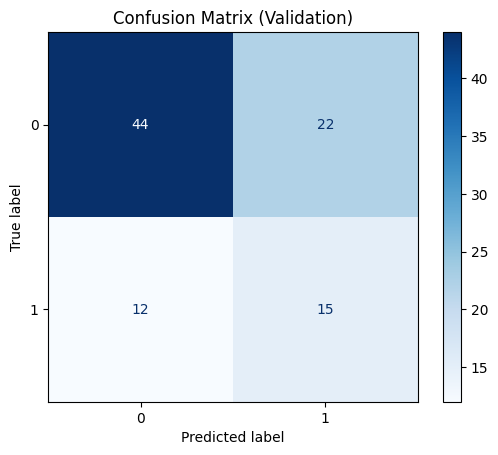

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.79      0.67      0.72        66
           1       0.41      0.56      0.47        27

    accuracy                           0.63        93
   macro avg       0.60      0.61      0.60        93
weighted avg       0.68      0.63      0.65        93



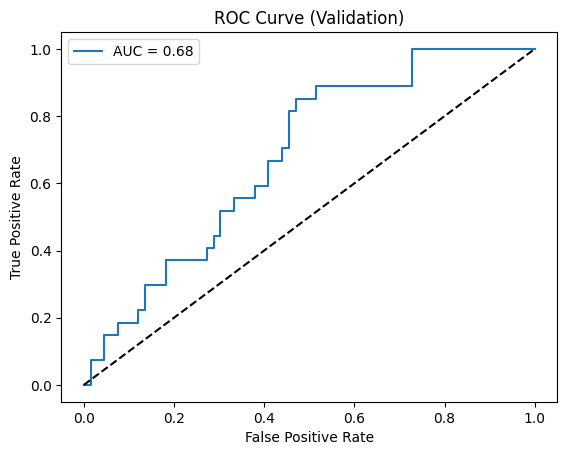

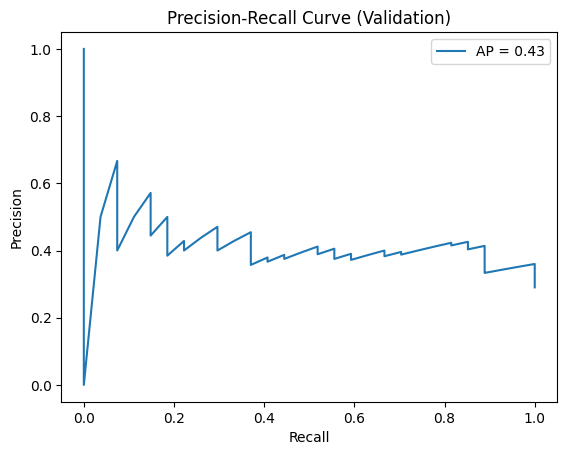

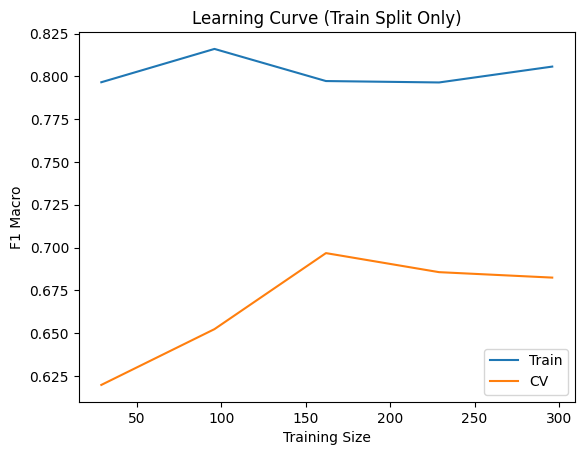

In [124]:
from sklearn.model_selection import train_test_split

# Split original training data into train and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Fit the best pipeline on the new training set
best_pipeline.fit(X_tr, y_tr)

# Predict on the validation set
y_val_pred = best_pipeline.predict(X_val)
y_val_proba = best_pipeline.predict_proba(X_val)[:, 1]

# 1. Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Validation)")
plt.show()

# 2. Classification Report
from sklearn.metrics import classification_report
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred))

# 3. ROC Curve and AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Validation)')
plt.legend()
plt.show()

# 4. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
ap = average_precision_score(y_val, y_val_proba)
plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Validation)')
plt.legend()
plt.show()

# 5. Learning Curve (optional, but now using only the train split)
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(
    best_pipeline, X_tr, y_tr, cv=5, scoring='f1_macro', n_jobs=-1
)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), label='CV')
plt.xlabel('Training Size')
plt.ylabel('F1 Macro')
plt.title('Learning Curve (Train Split Only)')
plt.legend()
plt.show()

In [ ]:
#To create the submission file

y_test_pred = best_pipeline.predict(X_test)
submission_df = pd.DataFrame({
    "ID": np.arange(1, len(y_test_pred) + 1),
    "Label": y_test_pred
})